In [1]:
%load_ext autoreload
%load_ext autotime

time: 263 µs (started: 2024-12-12 21:03:35 -08:00)


In [2]:
import numpy as np
import os
import pandas as pd
import sys
import time
import warnings
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Add WisIO to the path
sys.path.append(os.path.abspath("../"))

# Filter warnings
warnings.filterwarnings('ignore')

# Set the notebook to display Bokeh plots
output_notebook()

Loading BokehJS ...

time: 1.98 s (started: 2024-12-12 21:03:36 -08:00)


In [3]:
analyzer = "dftracer"

run_dir = f".wisio/{analyzer}/{int(time.time())}"
bottleneck_dir = f"{run_dir}/bottlenecks"
checkpoint_dir = f"{run_dir}/checkpoints"

cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:46185"

checkpoint = False
exclude_characteristics = ['node_count', 'app_count', 'proc_count', 'file_count']
logical_view_types = False
percentile = 0.95
time_granularity = 1e6
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/cm1/APP/node-1/v1/RAW/*.pfw.gz"

app_metrics = [
    'intensity',
    'io_compute_per',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    'time_norm',
    'time_per',
    # 'u_checkpoint_io_time',
    # 'u_io_time_per',
    # 'u_read_io_time',
]
dataloader_metrics = [
    'intensity',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]
posix_metrics = [
    'intensity',
    'data_bw',
    'data_time_norm',
    'data_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]

app_view_types = ['proc_name', 'time_range']
dataloader_view_types = ['proc_name', 'time_range']
posix_view_types = ['proc_name', 'time_range']

time_view_type = 'time_range'
unoverlapped_posix_only = False

output_compact = False
output_group_behavior = False
output_max_bottlenecks = 1
output_root_only = True


time: 1.54 ms (started: 2024-12-12 21:03:38 -08:00)


In [4]:
# Parameters
analyzer = "dftracer"
bottleneck_dir = "/p/lustre3/iopp/wisio-bottlenecks/dftracer-deepspeed-dlio-scr-opt-step100-axl1-node-16"
checkpoint = True
checkpoint_dir = "/p/lustre3/iopp/wisio-checkpoints/dftracer-deepspeed-dlio-scr-opt-step100-axl1-node-16"
logical_view_types = False
output_max_bottlenecks = 1
output_root_only = False
percentile = 0.9
run_dir = ".wisio/dftracer/deepspeed-dlio-scr-opt-step100-axl1-node-16"
# trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.6-develop/corona/megatron-deepspeed/dlio-scr-step100/node-16/v1/COMPACT/*.pfw.gz"
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.6-develop/corona/megatron-deepspeed/dlio-scr-opt-step100-axl1/node-16/v1/COMPACT/*.pfw.gz"

app_view_types = ["proc_name", "time_range"]
dataloader_view_types = ["proc_name", "time_range"]
posix_view_types = ["proc_name", "time_range"]

time: 1.09 ms (started: 2024-12-12 21:03:40 -08:00)


In [5]:
from distributed import Client
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from hydra.utils import instantiate
from wisio.cluster import ExternalCluster
from wisio.config import init_hydra_config_store
from wisio.utils.file_utils import ensure_dir

ensure_dir(run_dir)

with initialize(version_base=None, config_path=None):
    init_hydra_config_store()
    cfg = compose(
        config_name="config",
        overrides=[
            f"+analyzer={analyzer}",
            f"analyzer.bottleneck_dir={bottleneck_dir}",
            f"analyzer.checkpoint={checkpoint}",
            f"analyzer.checkpoint_dir={checkpoint_dir}",
            f"analyzer.time_granularity={65e6}",
            "cluster=external",
            "cluster.scheduler_address=tcp://127.0.0.1:46065",
            f"exclude_characteristics=[{','.join(exclude_characteristics)}]",
            f"hydra.run.dir={run_dir}",
            f"hydra.runtime.output_dir={run_dir}",
            f"logical_view_types={logical_view_types}",
            f"output.max_bottlenecks={output_max_bottlenecks}",
            f"output.root_only={output_root_only}",
            f"percentile={percentile}",
            f"trace_path={trace_path}",
        ],
        return_hydra_config=True,
    )
    HydraConfig.instance().set_config(cfg)
    cluster = instantiate(cfg.cluster)
    if isinstance(cluster, ExternalCluster):
        client = Client(cluster.scheduler_address)
    else:
        client = Client(cluster)
    analyzer = instantiate(cfg.analyzer)
    output = instantiate(cfg.output)

time: 3.65 s (started: 2024-12-12 21:03:42 -08:00)


In [6]:
client.dashboard_link

'http://127.0.0.1:8787/status'

time: 6.86 ms (started: 2024-12-12 21:03:46 -08:00)


In [7]:
client.restart()

<Client: 'tcp://127.0.0.1:46065' processes=0 threads=0, memory=0 B>

time: 4.1 s (started: 2024-12-12 21:03:46 -08:00)


In [8]:
from wisio.constants import Layer

result = analyzer.analyze_trace(
    trace_path=cfg.trace_path,
    bottleneck_rules=cfg.bottleneck_rules,
    exclude_bottlenecks=cfg.exclude_bottlenecks,
    exclude_characteristics=cfg.exclude_characteristics,
    logical_view_types=cfg.logical_view_types,
    percentile=cfg.percentile,
    metrics={
        'dlio': app_metrics,
        'compute': app_metrics,
        'dataloader': dataloader_metrics,
        'image': dataloader_metrics,
        'reader': dataloader_metrics,
        'checkpoint': dataloader_metrics,
        'posix': posix_metrics,
    },
    time_view_type=time_view_type,
    unoverlapped_posix_only=unoverlapped_posix_only,
    view_types={
        'dlio': app_view_types,
        'compute': app_view_types,
        'dataloader': dataloader_view_types,
        'image': dataloader_view_types,
        'reader': dataloader_view_types,
        'checkpoint': dataloader_view_types,
        'posix': posix_view_types,
    },
)

time: 6min 43s (started: 2024-12-12 21:03:50 -08:00)


In [11]:
traces, hlms, main_views, metric_boundaries, views, flat_views = result

time: 768 µs (started: 2024-12-12 21:17:21 -08:00)


In [12]:
traces.to_parquet(f"{checkpoint_dir}/_traces", write_metadata_file=True)

time: 17.7 s (started: 2024-12-12 21:17:39 -08:00)


In [10]:
traces['image_id'].nunique().compute()

6156284

time: 8.51 s (started: 2024-12-07 13:14:19 -08:00)


In [11]:
traces['proc_name'].nunique().compute()

2432

time: 7.73 s (started: 2024-12-07 13:14:27 -08:00)


In [11]:
images = flat_views[('proc_name',)][flat_views[('proc_name',)].columns[flat_views[('proc_name',)].columns.str.contains('image')]]
# images['image_ops'] = images['image_count'] / images['image_time']
images[~images['image_time'].isna()].sort_index()

image_bw  image_bw_score  image_count  \
proc_name                                                              
app#corona188#1995927#1996131       0.0               0       8016.0   
app#corona188#1995927#1996698       0.0               0       8016.0   
app#corona188#1995927#1997139       0.0               0       8016.0   
app#corona188#1995927#1997706       0.0               0       8016.0   
app#corona188#1995927#1998211       0.0               0       8016.0   
...                                 ...             ...          ...   
app#corona233#2864518#2865469       0.0               0       8016.0   
app#corona233#2864518#2866036       0.0               0       8016.0   
app#corona233#2864518#2866540       0.0               0       8016.0   
app#corona233#2864518#2866813       0.0               0       8016.0   
app#corona233#2864518#2867617       0.0               0       8016.0   

                               image_count_per  image_count_per_score  \
proc_name                                                               
app#corona188#1995927#1996131         0.001302                      2   
app#corona188#1995927#1996698         0.001302                      2   
app#corona188#1995927#1997139         0.001302                      2   
app#corona188#1995927#1997706         0.001302                      2   
app#corona188#1995927#1998211         0.001302                      2   
...                                        ...                    ...   
app#corona233#2864518#2865469         0.001302                      2   
app#corona233#2864518#2866036         0.001302                      2   
app#corona233#2864518#2866540         0.001302                      2   
app#corona233#2864518#2866813         0.001302                      2   
app#corona233#2864518#2867617         0.001302                      2   

                               image_intensity  image_intensity_score  \
proc_name                                                               
app#corona188#1995927#1996131              0.0                      0   
app#corona188#1995927#1996698              0.0                      0   
app#corona188#1995927#1997139              0.0                      0   
app#corona188#1995927#1997706              0.0                      0   
app#corona188#1995927#1998211              0.0                      0   
...                                        ...                    ...   
app#corona233#2864518#2865469              0.0                      0   
app#corona233#2864518#2866036              0.0                      0   
app#corona233#2864518#2866540              0.0                      0   
app#corona233#2864518#2866813              0.0                      0   
app#corona233#2864518#2867617              0.0                      0   

                                 image_ops  image_ops_rank  \
proc_name                                                    
app#corona188#1995927#1996131  6194.922111        0.085938   
app#corona188#1995927#1996698  6201.358481        0.071615   
app#corona188#1995927#1997139  6136.561459        0.240885   
app#corona188#1995927#1997706  6290.971561        0.001302   
app#corona188#1995927#1998211  6159.605711        0.177083   
...                                    ...             ...   
app#corona233#2864518#2865469  6016.351326        0.713542   
app#corona233#2864518#2866036  5902.715647        0.958333   
app#corona233#2864518#2866540  5987.666125        0.803385   
app#corona233#2864518#2866813  5962.382543        0.869792   
app#corona233#2864518#2867617  5879.716665        0.972656   

                               image_ops_rank_score  ...  image_time  \
proc_name                                            ...               
app#corona188#1995927#1996131                     3  ...    1.293963   
app#corona188#1995927#1996698                     3  ...     1.29262   
app#corona188#1995927#1997139                     4  ...    1.306269   
app#corona188#1995927#19977

time: 27 ms (started: 2024-12-07 15:05:13 -08:00)


In [12]:
images = flat_views[('time_range',)][flat_views[('time_range',)].columns[flat_views[('time_range',)].columns.str.contains('image')]]
# images['image_ops'] = images['image_count'] / images['image_time']
images

image_bw  image_bw_score  image_count  image_count_per  \
time_range                                                           
0               <NA>               0          NaN              NaN   
1               <NA>               0          NaN              NaN   
2                0.0               0      47104.0         0.007651   
3                0.0               0      55296.0         0.008982   
4                0.0               0      53248.0         0.008649   
...              ...             ...          ...              ...   
125              0.0               0      49152.0         0.007984   
126              0.0               0      55296.0         0.008982   
127              0.0               0      55296.0         0.008982   
128              0.0               0      45056.0         0.007319   
129             <NA>               0          NaN              NaN   

            image_count_per_score  image_intensity  image_intensity_score  \
time_range                                                                  
0                               0             <NA>                      0   
1                               0             <NA>                      0   
2                               2              0.0                      0   
3                               2              0.0                      0   
4                               2              0.0                      0   
...                           ...              ...                    ...   
125                             2              0.0                      0   
126                             2              0.0                      0   
127                             2              0.0                      0   
128                             2              0.0                      0   
129                             0             <NA>                      0   

               image_ops  image_ops_rank  image_ops_rank_score  ...  \
time_range                                                      ...   
0                    NaN             NaN                     0  ...   
1                    NaN             NaN                     0  ...   
2           7.903886e+05        1.000000                     8  ...   
3           3.691075e+06        0.598425                     6  ...   
4           3.469603e+06        0.803150                     7  ...   
...                  ...             ...                   ...  ...   
125         4.492460e+06        0.007874                     2  ...   
126         3.990762e+06        0.314961                     5  ...   
127         4.081488e+06        0.149606                     4  ...   
128         4.072675e+06        0.165354                     4  ...   
129                  NaN             NaN                     0  ...   

            image_time  image_time_norm  image_time_norm_score  \
time_range                                                       
0                 <NA>             <NA>                      0   
1                 <NA>             <NA>                      0   
2             0.059596         0.000003                      1   
3             0.014981         0.000001                      1   
4             0.015347         0.000001                      1   
...                ...              ...                    ...   
125           0.010941         0.000001                      1   
126           0.013856         0.000001                      1   
127           0.013548         0.000001                      1   
128           0.011063         0.000001                      1   
129               <NA>             <NA>                      0   

            image_time_per  image_time_per_score  u_image_time  \
time_range                                                       
0                     <NA>                     0          <NA>   
1                     <NA>                     0          <NA>   
2                 0.035269                     3    

time: 25.5 ms (started: 2024-12-07 15:05:20 -08:00)


<Axes: xlabel='time_range'>

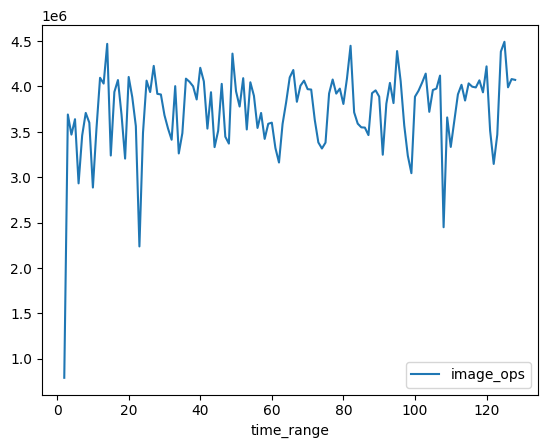

time: 666 ms (started: 2024-12-07 15:05:24 -08:00)


In [13]:
images[['image_ops']].plot()

In [12]:
from dask.distributed import wait

persisted_traces = traces.persist()
wait(persisted_traces)

DoneAndNotDoneFutures(done={<Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-f96929c7dcd24caff6eac365be1c1430', 83)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-f96929c7dcd24caff6eac365be1c1430', 7)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-f96929c7dcd24caff6eac365be1c1430', 43)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-f96929c7dcd24caff6eac365be1c1430', 50)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-f96929c7dcd24caff6eac365be1c1430', 105)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-f96929c7dcd24caff6eac365be1c1430', 114)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-f96929c7dcd24caff6eac365be1c1430', 80)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-f96929c7dcd24caff6eac365be1c1430', 96)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-f96929c7dcd24caff6eac365be1c143

time: 30.7 ms (started: 2024-12-01 20:51:38 -08:00)


In [22]:
flat_views[('time_range',)].sort_index().to_csv('dlio_scr_opt_step100_time_range.csv')

time: 146 ms (started: 2024-12-12 19:01:49 -08:00)


In [23]:
flat_views[('proc_name',)].sort_index().to_csv('dlio_scr_opt_step100_proc_name.csv')

time: 1.77 s (started: 2024-12-12 19:01:49 -08:00)


In [24]:
flat_views[('proc_name', 'proc_id')].sort_index().to_csv('dlio_scr_opt_step100_proc_id.csv')

time: 96.2 ms (started: 2024-12-12 19:01:51 -08:00)


In [25]:
flat_views[('proc_name', 'host_name')].sort_index().to_csv('dlio_scr_opt_step100_host_name.csv')

time: 55.3 ms (started: 2024-12-12 19:01:51 -08:00)


In [14]:
flat_views[('proc_name',)][
    [
        'compute_time',
        'checkpoint_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'dataloader_time',
        'dataloader_sample_time',
        'posix_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        'u_dataloader_sample_time',
        'u_posix_time',
    ]
].max()

compute_time                7327.379578
checkpoint_time               969.30619
dlio_compute_time           8205.874732
dlio_stall_time               47.912766
dataloader_time               16.020986
dataloader_sample_time         1.413214
posix_time                   826.264324
u_checkpoint_time                   0.0
u_dataloader_time              1.413214
u_dataloader_sample_time       1.413214
u_posix_time                   2.661759
dtype: double[pyarrow]

time: 6.31 ms (started: 2024-12-09 13:59:41 -08:00)


In [15]:
flat_views[('time_range',)][
    [
        'compute_time',
        'checkpoint_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'dataloader_time',
        'dataloader_sample_time',
        'posix_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        'u_dataloader_sample_time',
        'u_posix_time',
    ]
].sum()

compute_time                7327.394178
checkpoint_time               969.33358
dlio_compute_time           8206.173689
dlio_stall_time               48.161224
dataloader_time               17.710757
dataloader_sample_time         1.689771
posix_time                   938.967072
u_checkpoint_time            106.116354
u_dataloader_time             16.020986
u_dataloader_sample_time            0.0
u_posix_time                  81.500365
dtype: double[pyarrow]

time: 6.67 ms (started: 2024-12-09 13:59:58 -08:00)


In [20]:
flat_views[('time_range',)][
    [
        'compute_time',
        'checkpoint_time',
        # 'dlio_compute_time',
        # 'dlio_stall_time',
        'dlio_time',
        'dataloader_time',
        'reader_time',
        # 'dataloader_sample_time',
        'posix_time',
        # 'u_checkpoint_time',
        # 'u_dataloader_time',
        # 'u_dataloader_sample_time',
        # 'u_posix_time',
    ]
].sum()

compute_time       7327.394178
checkpoint_time    2090.770008
dlio_time          8253.385782
dataloader_time      17.710757
reader_time           0.292425
posix_time          938.967072
dtype: double[pyarrow]

time: 5.37 ms (started: 2024-12-07 15:06:08 -08:00)


In [28]:
import pandas as pd
from wisio.metrics import set_metric_scores

time_range_view = pd.read_csv('dlio_scr_opt_step100_time_range.csv').copy().set_index('time_range')

time_range_view.index = time_range_view.index.astype(str)

time_range_view['reader_r3_time'] = time_range_view['reader_time'].rolling(window=4).sum()
time_range_view['reader_r3_gauss_time'] = time_range_view['reader_time'].rolling(window=4, win_type='gaussian').sum(std=1)
time_range_view['reader_r3_hann_time'] = time_range_view['reader_time'].rolling(window=4, win_type='hann').sum()

time_range_view['reader_r3_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_r3_time'].sum()
time_range_view['reader_r3_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_r3_gauss_time'].sum()
time_range_view['reader_r3_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_r3_hann_time'].sum()

time_range_view['reader_r3_2_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_time'].sum()
time_range_view['reader_r3_2_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_time'].sum()
time_range_view['reader_r3_2_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_time'].sum()

time_range_view['reader_r3_time_norm'] = time_range_view['reader_r3_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['reader_r3_gauss_time_norm'] = time_range_view['reader_r3_gauss_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['reader_r3_hann_time_norm'] = time_range_view['reader_r3_hann_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()

time_range_view['posix_read_r3_time'] = time_range_view['posix_read_time'].rolling(window=4).sum()
time_range_view['posix_read_r3_gauss_time'] = time_range_view['posix_read_time'].rolling(window=4, win_type='gaussian').sum(std=1)
time_range_view['posix_read_r3_hann_time'] = time_range_view['posix_read_time'].rolling(window=4, win_type='hann').sum()

time_range_view['posix_read_r3_time_per'] = time_range_view['posix_read_r3_time'] / time_range_view['posix_read_r3_time'].sum()
time_range_view['posix_read_r3_gauss_time_per'] = time_range_view['posix_read_r3_gauss_time'] / time_range_view['posix_read_r3_gauss_time'].sum()
time_range_view['posix_read_r3_hann_time_per'] = time_range_view['posix_read_r3_hann_time'] / time_range_view['posix_read_r3_hann_time'].sum()

time_range_view['posix_read_r3_time_norm'] = time_range_view['posix_read_r3_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['posix_read_r3_gauss_time_norm'] = time_range_view['posix_read_r3_gauss_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['posix_read_r3_hann_time_norm'] = time_range_view['posix_read_r3_hann_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()

# time_range_view['dlio_compute_util'] = time_range_view['dlio_compute_time'].astype(
#     float
# ) / (
#     time_range_view['dlio_compute_time'].astype(float)
#     + time_range_view['dlio_stall_time'].astype(float)
#     + time_range_view['checkpoint_time'].astype(float)
# )

time_range_view = set_metric_scores(time_range_view)
# time_range_view['dlio_compute_util_score'] = 8 - time_range_view['dlio_compute_util_score']
# time_range_view['dlio_compute_util_score'] = time_range_view['dlio_compute_util_score'].mask(time_range_view['dlio_compute_time'] == 0, pd.NA)

# norm_cols = [col for col in time_range_view.columns if 'norm_score' in col]
# norm_cols = ['dlio_compute_util_score'] + norm_cols
# norm_cols

dlio_cols = ['dlio_compute_util_score'] # [col for col in time_range_view.columns if 'dlio_' in col and col.endswith('_score')]
dataloader_cols = [col for col in time_range_view.columns if 'dataloader_' in col and col.endswith('_score')]
image_cols = [col for col in time_range_view.columns if 'image_' in col and col.endswith('_score')]
checkpoint_cols = [col for col in time_range_view.columns if 'checkpoint_' in col and col.endswith('_score')]
posix_cols = [col for col in time_range_view.columns if 'posix_' in col and col.endswith('_score')]
# norm_cols = [col for col in time_range_view.columns if '_score' in col]
# norm_cols = ['dlio_compute_util_score'] + norm_cols
norm_cols = dlio_cols + checkpoint_cols + dataloader_cols + image_cols + posix_cols

norm_cols = [col for col in norm_cols if 'slope' not in col]
# time_range_view[['dlio_compute_util', 'dlio_compute_util_score']]

norm_scores = time_range_view[norm_cols]
norm_scores

dlio_compute_util_score  checkpoint_bw_score  \
time_range                                                 
0                              <NA>                    0   
1                              <NA>                    0   
2                                 0                 <NA>   
3                                 0                 <NA>   
4                                 0                 <NA>   
...                             ...                  ...   
125                               0                 <NA>   
126                               0                 <NA>   
127                               0                 <NA>   
128                               2                    0   
129                            <NA>                    0   

            checkpoint_compute_per_score  checkpoint_count_per_score  \
time_range                                                             
0                                   <NA>                           4   
1                                   <NA>                           4   
2                                   <NA>                        <NA>   
3                                   <NA>                        <NA>   
4                                   <NA>                        <NA>   
...                                  ...                         ...   
125                                 <NA>                        <NA>   
126                                 <NA>                        <NA>   
127                                 <NA>                        <NA>   
128                                    6                           3   
129                                 <NA>                           3   

            checkpoint_intensity_score  checkpoint_ops_rank_score  \
time_range                                                          
0                                    0                          3   
1                                    0                          3   
2                                 <NA>                       <NA>   
3                                 <NA>                       <NA>   
4                                 <NA>                       <NA>   
...                                ...                        ...   
125                               <NA>                       <NA>   
126                               <NA>                       <NA>   
127                               <NA>                       <NA>   
128                                  0                          6   
129                                  0                          3   

            checkpoint_time_norm_score  checkpoint_time_per_score  \
time_range                                                          
0                                    2                          3   
1                                    2                          3   
2                                 <NA>                       <NA>   
3                                 <NA>                       <NA>   
4                                 <NA>                       <NA>   
...                                ...                        ...   
125                               <NA>                       <NA>   
126                               <NA>                       <NA>   
127                               <NA>                       <NA>   
128                                  2                          3   
129                                  1                          1   

            u_checkpoint_time_norm_score  u_checkpoint_time_per_score  ...  \
time_range                                                             ...   
0                                      2                            5  ...   
1                                      2                            4  ...   
2                                   <NA>                         <NA>  ...   
3                                   <NA>                         <NA>  ...   
4                             

time: 354 ms (started: 2024-12-12 19:02:32 -08:00)


In [29]:
import pandas as pd

norm_scores_all = norm_scores.copy()
for col in norm_cols:
    norm_scores2 = norm_scores.copy()
    norm_scores2['score_col'] = col
    norm_scores2['score'] = norm_scores2[col]
    norm_scores_all = pd.concat([norm_scores_all, norm_scores2])
norm_scores_all.drop(columns=norm_cols).dropna()

score_col  score
time_range                                     
2                dlio_compute_util_score      0
3                dlio_compute_util_score      0
4                dlio_compute_util_score      0
5                dlio_compute_util_score      0
6                dlio_compute_util_score      2
...                                  ...    ...
125         u_posix_write_time_per_score      0
126         u_posix_write_time_per_score      0
127         u_posix_write_time_per_score      0
128         u_posix_write_time_per_score      0
129         u_posix_write_time_per_score      5

[18886 rows x 2 columns]

time: 7.78 s (started: 2024-12-12 19:02:32 -08:00)


In [30]:
from math import pi

import pandas as pd

from bokeh.models import BasicTicker, PrintfTickFormatter
from bokeh.plotting import figure, show
from bokeh.sampledata.unemployment1948 import data
from bokeh.transform import linear_cmap
from bokeh.palettes import RdYlGn, Reds, TolYlOrBr
from bokeh.io import output_notebook

output_notebook()

VAL_COL = 'proc_id'

years = list(time_range_view.index.astype(str))
months = list(reversed(norm_cols))

# reshape to 1D array or rates with a month and year for each row.
df = norm_scores_all.drop(
    columns=norm_cols
).reset_index().dropna()  # pd.DataFrame(data.stack(), columns=['rate']).reset_index()

# this is the colormap from the original NYTimes plot
colors = [
    "#75968f",
    "#a5bab7",
    "#c9d9d3",
    "#e2e2e2",
    "#dfccce",
    "#ddb7b1",
    "#cc7878",
    "#933b41",
    "#550b1d",
]
mapper = linear_cmap(
    field_name="score",
    palette=Reds[8][::-1],  # Green-to-Red palette with 11 steps
    low=0,
    high=8,
)

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(
    # title=f"US Unemployment ({years[0]} - {years[-1]})",
    x_range=years,
    y_range=months,
    x_axis_location="above",
    width=900,
    height=400,
    tools=TOOLS,
    toolbar_location='below',
    tooltips=[('date', '@time_range'), ('score', '@score%')],
)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3

r = p.rect(
    x="time_range",
    y="score_col",
    width=1,
    height=1,
    source=df,
    fill_color=mapper, # linear_cmap("score", colors, low=0, high=8),
    line_color=None,
)

p.add_layout(
    r.construct_color_bar(
        major_label_text_font_size="7px",
        ticker=BasicTicker(desired_num_ticks=len(colors)),
        formatter=PrintfTickFormatter(format="%d%%"),
        label_standoff=6,
        border_line_color=None,
        padding=5,
    ),
    'right',
)

show(p)

Loading BokehJS ...

time: 196 ms (started: 2024-12-12 19:02:40 -08:00)


Feature Importances (Random Forest):
checkpoint_ops_rank_score       0.309553
posix_bw_score                  0.238810
checkpoint_compute_per_score    0.205139
posix_write_ssd_bw_score        0.068505
u_checkpoint_time_norm_score    0.033084
                                  ...   
posix_read_bw_score             0.000000
posix_read_count_per_score      0.000000
posix_read_intensity_score      0.000000
posix_read_lustre_bw_score      0.000000
u_reader_time_per_score         0.000000
Length: 189, dtype: float64


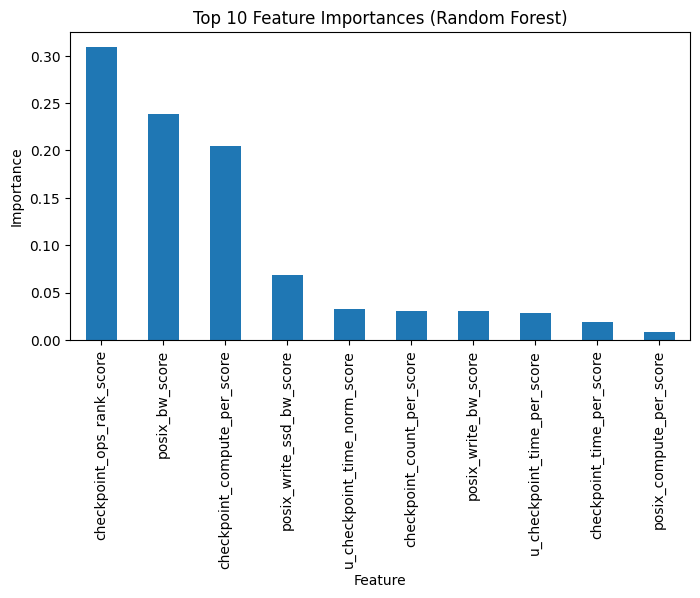

time: 366 ms (started: 2024-12-12 19:02:47 -08:00)


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Splitting data into features (X) and target (y)
# df = df.dropna()
df = pd.read_csv('dlio_scr_opt_step100_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data_' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target].fillna(0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display top features
print("Feature Importances (Random Forest):")
print(feature_importances)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()


Top correlations with 'dlio_compute_util_score':
dlio_compute_util_score               1.000000
posix_bw_score                        0.906692
posix_write_time_norm_score           0.904239
posix_time_norm_score                 0.885279
posix_write_bw_score                  0.879454
                                        ...   
u_reader_preprocess_time_per_score         NaN
u_reader_sample_time_norm_score            NaN
u_reader_sample_time_per_score             NaN
u_reader_time_norm_score                   NaN
u_reader_time_per_score                    NaN
Name: dlio_compute_util_score, Length: 146, dtype: float64


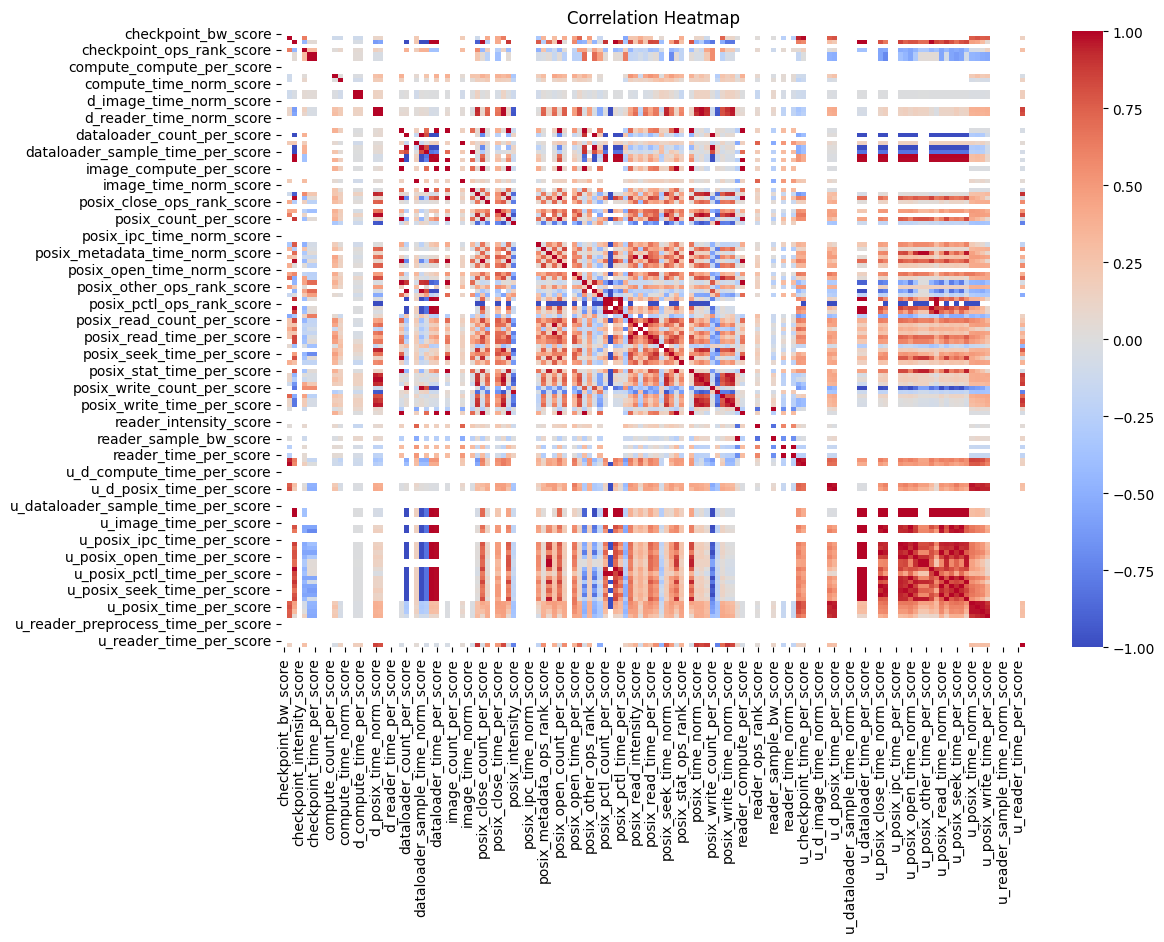

time: 1.06 s (started: 2024-12-09 13:50:18 -08:00)


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your dataframe containing the scores

df = pd.read_csv('dlio_scr_opt_step100_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target]


# df = norm_scores.copy()

# Calculate correlation matrix
correlation_matrix = df[score_cols].copy().corr()

# Focus on correlations with 'dlio_compute_util_score'
target_correlation = correlation_matrix[target].sort_values(ascending=False)

# Print correlations
print("Top correlations with 'dlio_compute_util_score':")
print(target_correlation)

# Plot a heatmap for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

# Optional: Heatmap focusing only on top 10 correlated features
# top_features = target_correlation.index[:10]  # Top 10 features
# plt.figure(figsize=(10, 6))
# sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', center=0, cbar=True)
# plt.title('Heatmap of Top 10 Correlated Features with dlio_compute_util_score')
# plt.show()


Feature Importances (Random Forest):
posix_read_count_per_score            0.090000
u_dataloader_sample_time_per_score    0.069803
posix_time_per_score                  0.050000
dataloader_count_per_score            0.050000
dataloader_time_per_score             0.049480
                                        ...   
posix_ipc_count_per_score             0.000000
posix_intensity_score                 0.000000
posix_compute_per_score               0.000000
posix_close_time_per_score            0.000000
u_reader_time_per_score               0.000000
Length: 145, dtype: float64


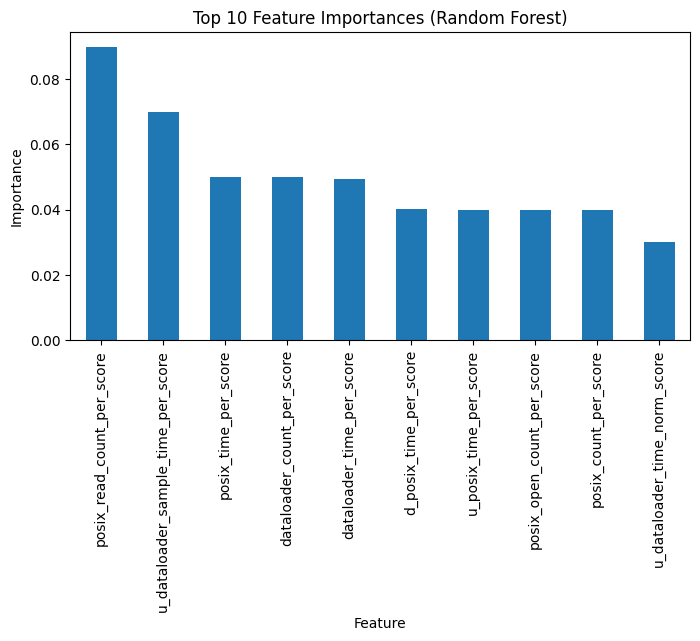

time: 521 ms (started: 2024-12-09 13:50:38 -08:00)


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Splitting data into features (X) and target (y)
# df = df.dropna()
df = pd.read_csv('dlio_scr_opt_step100_proc_name.csv').copy().set_index('proc_name')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target].fillna(0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display top features
print("Feature Importances (Random Forest):")
print(feature_importances)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()


Top correlations with 'dlio_compute_util_score':
checkpoint_bw_score               NaN
checkpoint_compute_per_score      NaN
checkpoint_count_per_score        NaN
checkpoint_intensity_score        NaN
checkpoint_ops_rank_score         NaN
                                   ..
u_reader_sample_time_norm_score   NaN
u_reader_sample_time_per_score    NaN
u_reader_time_norm_score          NaN
u_reader_time_per_score           NaN
dlio_compute_util_score           NaN
Name: dlio_compute_util_score, Length: 146, dtype: float64


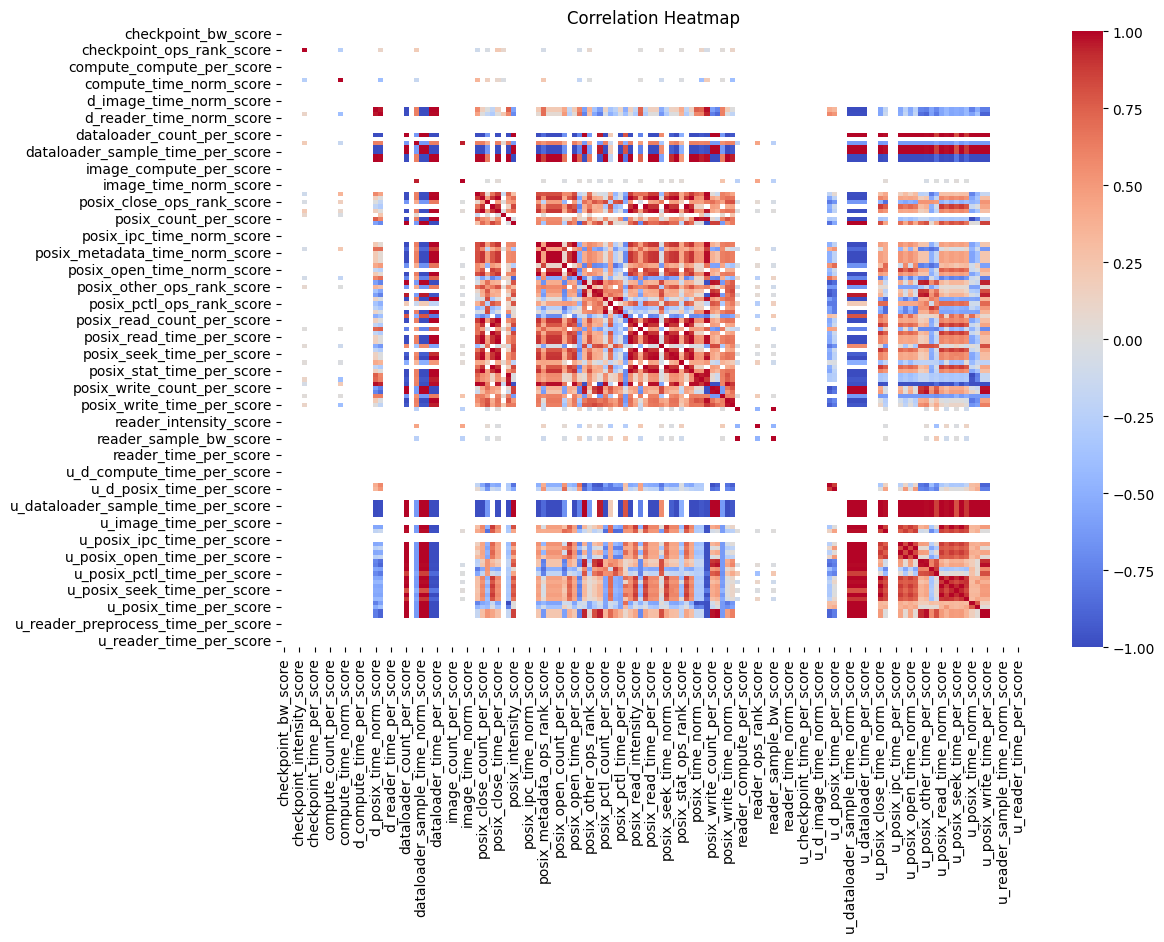

time: 953 ms (started: 2024-12-09 13:50:45 -08:00)


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your dataframe containing the scores

df = pd.read_csv('dlio_scr_opt_step100_proc_name.csv').copy().set_index('proc_name')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target].fillna(0)


# df = norm_scores.copy()

# Calculate correlation matrix
correlation_matrix = df[score_cols].copy().corr()

# Focus on correlations with 'dlio_compute_util_score'
target_correlation = correlation_matrix[target].sort_values(ascending=False)

# Print correlations
print("Top correlations with 'dlio_compute_util_score':")
print(target_correlation)

# Plot a heatmap for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

# Optional: Heatmap focusing only on top 10 correlated features
# top_features = target_correlation.index[:10]  # Top 10 features
# plt.figure(figsize=(10, 6))
# sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', center=0, cbar=True)
# plt.title('Heatmap of Top 10 Correlated Features with dlio_compute_util_score')
# plt.show()


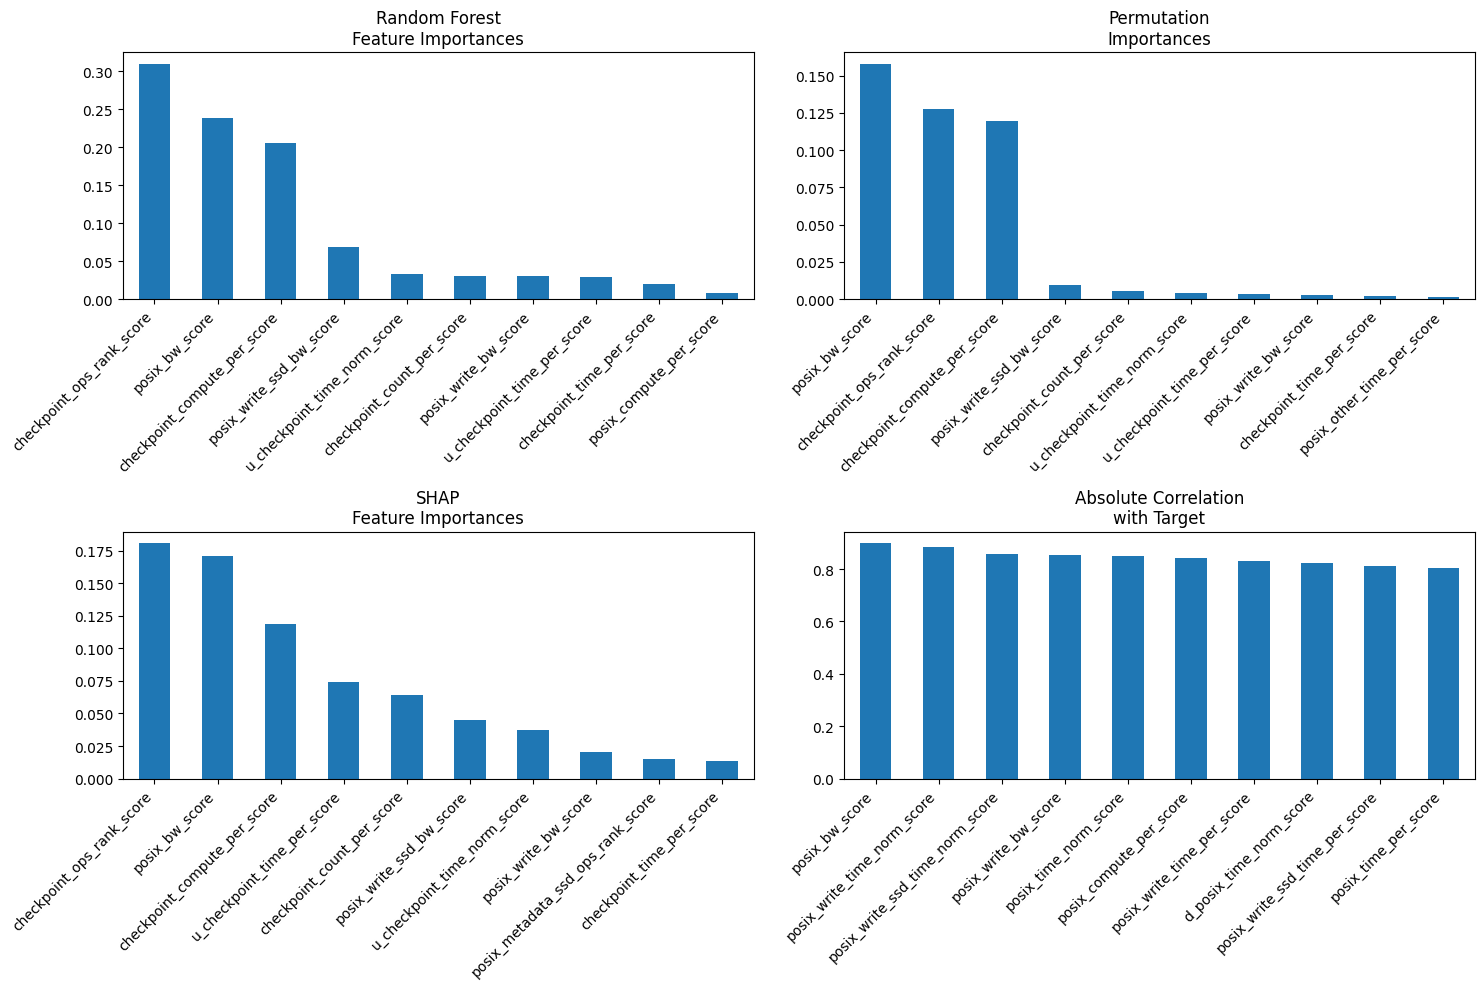

Top Features Across Different Methods:

Random Forest Importances:
 checkpoint_ops_rank_score       0.309553
posix_bw_score                  0.238810
checkpoint_compute_per_score    0.205139
posix_write_ssd_bw_score        0.068505
u_checkpoint_time_norm_score    0.033084
checkpoint_count_per_score      0.030568
posix_write_bw_score            0.030310
u_checkpoint_time_per_score     0.028466
checkpoint_time_per_score       0.019482
posix_compute_per_score         0.008488
dtype: float64

Permutation Importances:
 posix_bw_score                  0.157913
checkpoint_ops_rank_score       0.127310
checkpoint_compute_per_score    0.119282
posix_write_ssd_bw_score        0.009355
checkpoint_count_per_score      0.005158
u_checkpoint_time_norm_score    0.003795
u_checkpoint_time_per_score     0.003738
posix_write_bw_score            0.002651
checkpoint_time_per_score       0.002217
posix_other_time_per_score      0.001275
dtype: float64

SHAP Importances:
 checkpoint_ops_rank_score          

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt
import seaborn as sns

def multi_modal_feature_importance(df, target='dlio_compute_util_score'):
    # Prepare data
    score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data_' not in col]
    score_cols = score_cols + [target]
    
    X = df[score_cols].drop(columns=[target])
    y = df[target].fillna(0)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 1. Random Forest Feature Importance
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    
    # 2. Permutation Importance
    perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
    perm_importances = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)
    
    # 3. SHAP Values
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_test)
    shap_importance = pd.Series(np.abs(shap_values).mean(axis=0), index=X.columns).sort_values(ascending=False)
    
    # 4. Correlation Analysis
    correlation_matrix = X.corrwith(y)
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Random Forest Importances
    plt.subplot(2, 2, 1)
    rf_importances.head(10).plot(kind='bar')
    plt.title('Random Forest\nFeature Importances')
    plt.xticks(rotation=45, ha='right')
    
    # Permutation Importances
    plt.subplot(2, 2, 2)
    perm_importances.head(10).plot(kind='bar')
    plt.title('Permutation\nImportances')
    plt.xticks(rotation=45, ha='right')
    
    # SHAP Importances
    plt.subplot(2, 2, 3)
    shap_importance.head(10).plot(kind='bar')
    plt.title('SHAP\nFeature Importances')
    plt.xticks(rotation=45, ha='right')
    
    # Correlation Heatmap
    plt.subplot(2, 2, 4)
    correlation_with_target = X.corrwith(y).abs().sort_values(ascending=False)
    correlation_with_target.head(10).plot(kind='bar')
    plt.title('Absolute Correlation\nwith Target')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print Top Features
    print("Top Features Across Different Methods:")
    print("\nRandom Forest Importances:\n", rf_importances.head(10))
    print("\nPermutation Importances:\n", perm_importances.head(10))
    print("\nSHAP Importances:\n", shap_importance.head(10))
    print("\nCorrelation with Target:\n", correlation_with_target.head(10))

# Usage
df = pd.read_csv('dlio_scr_opt_step100_time_range.csv').copy().set_index('time_range')
multi_modal_feature_importance(df)

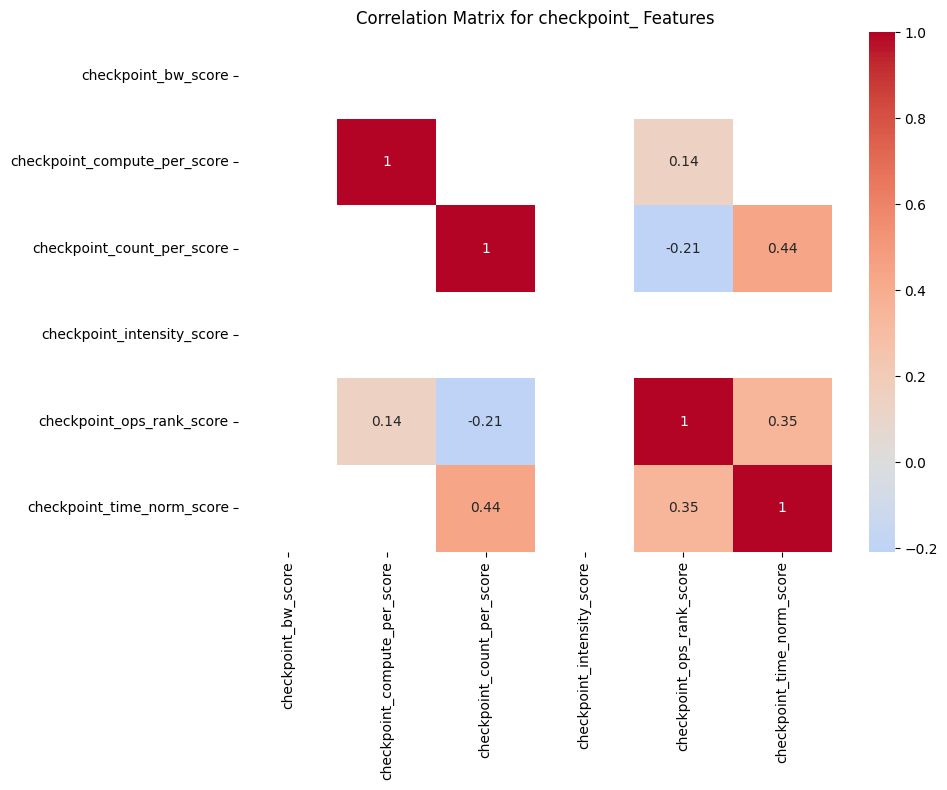


checkpoint_ Category:
Original features: ['checkpoint_bw_score', 'checkpoint_compute_per_score', 'checkpoint_count_per_score', 'checkpoint_intensity_score', 'checkpoint_ops_rank_score', 'checkpoint_time_norm_score']
Reduced features: ['checkpoint_bw_score', 'checkpoint_compute_per_score', 'checkpoint_count_per_score', 'checkpoint_intensity_score', 'checkpoint_ops_rank_score', 'checkpoint_time_norm_score']
Dropped features: set()


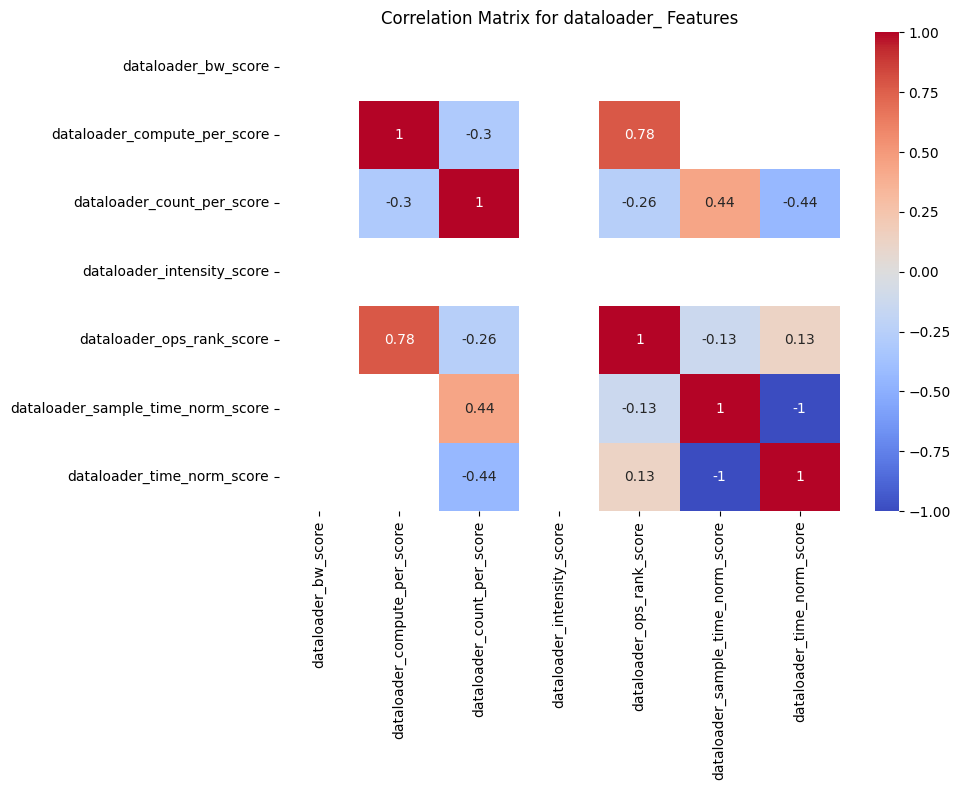


dataloader_ Category:
Original features: ['dataloader_bw_score', 'dataloader_compute_per_score', 'dataloader_count_per_score', 'dataloader_intensity_score', 'dataloader_ops_rank_score', 'dataloader_sample_time_norm_score', 'dataloader_time_norm_score']
Reduced features: ['dataloader_bw_score', 'dataloader_compute_per_score', 'dataloader_count_per_score', 'dataloader_intensity_score', 'dataloader_ops_rank_score', 'dataloader_sample_time_norm_score']
Dropped features: {'dataloader_time_norm_score'}


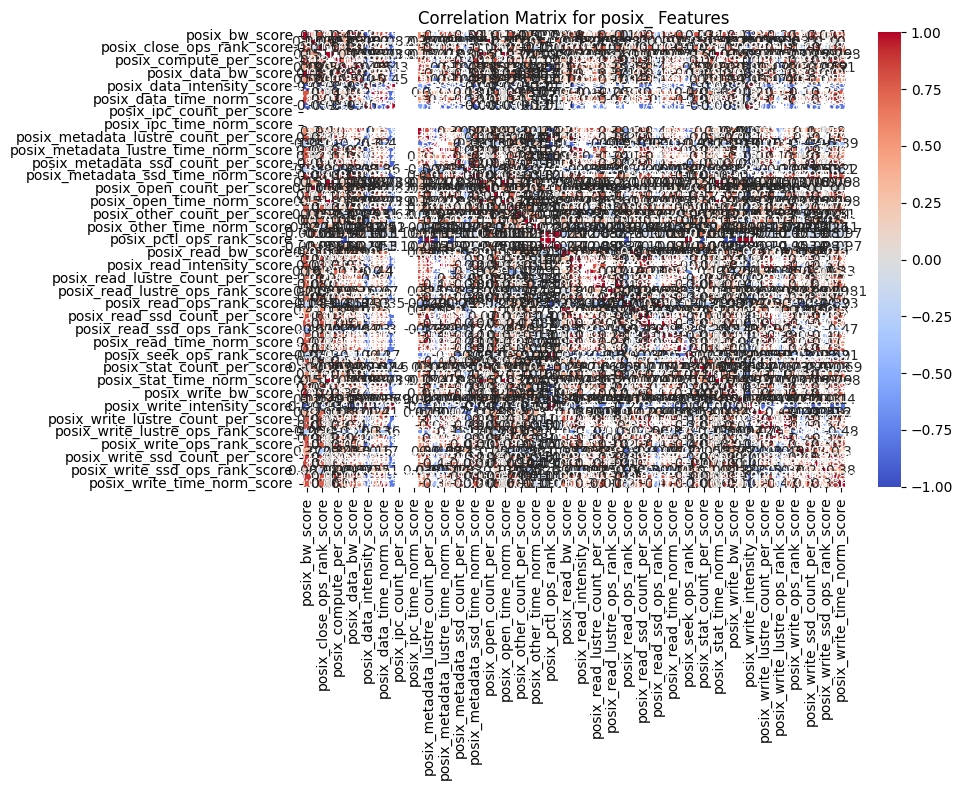


posix_ Category:
Original features: ['posix_bw_score', 'posix_close_count_per_score', 'posix_close_ops_rank_score', 'posix_close_time_norm_score', 'posix_compute_per_score', 'posix_count_per_score', 'posix_data_bw_score', 'posix_data_count_per_score', 'posix_data_intensity_score', 'posix_data_ops_rank_score', 'posix_data_time_norm_score', 'posix_intensity_score', 'posix_ipc_count_per_score', 'posix_ipc_ops_rank_score', 'posix_ipc_time_norm_score', 'posix_metadata_count_per_score', 'posix_metadata_lustre_count_per_score', 'posix_metadata_lustre_ops_rank_score', 'posix_metadata_lustre_time_norm_score', 'posix_metadata_ops_rank_score', 'posix_metadata_ssd_count_per_score', 'posix_metadata_ssd_ops_rank_score', 'posix_metadata_ssd_time_norm_score', 'posix_metadata_time_norm_score', 'posix_open_count_per_score', 'posix_open_ops_rank_score', 'posix_open_time_norm_score', 'posix_ops_rank_score', 'posix_other_count_per_score', 'posix_other_ops_rank_score', 'posix_other_time_norm_score', 'posix

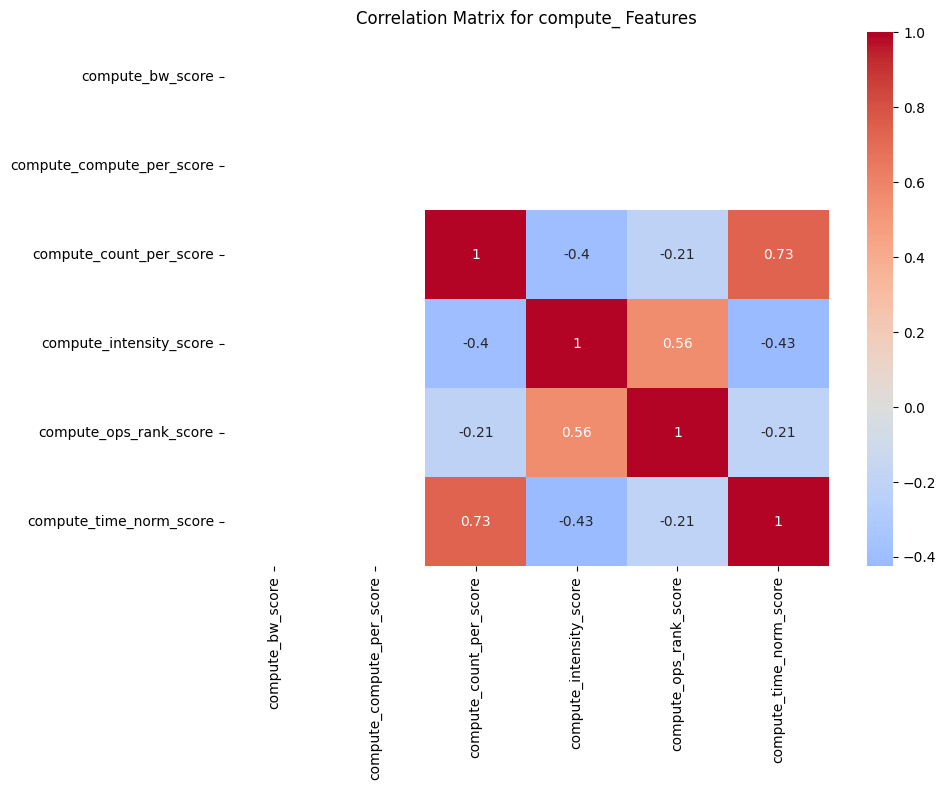


compute_ Category:
Original features: ['compute_bw_score', 'compute_compute_per_score', 'compute_count_per_score', 'compute_intensity_score', 'compute_ops_rank_score', 'compute_time_norm_score']
Reduced features: ['compute_bw_score', 'compute_compute_per_score', 'compute_count_per_score', 'compute_intensity_score', 'compute_ops_rank_score', 'compute_time_norm_score']
Dropped features: set()


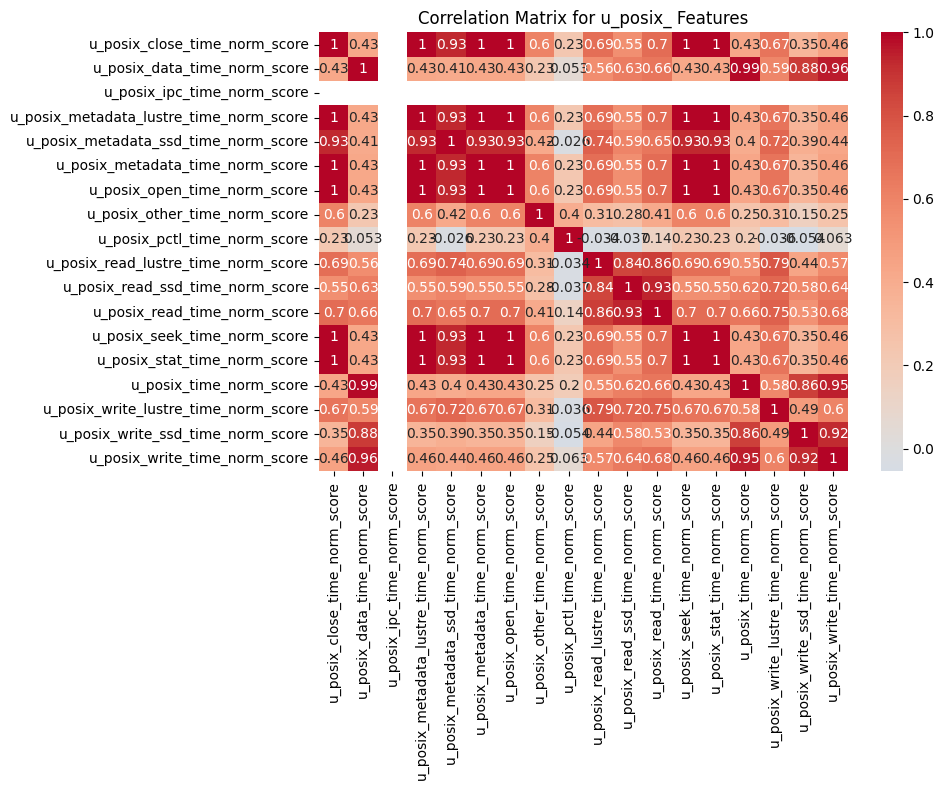


u_posix_ Category:
Original features: ['u_posix_close_time_norm_score', 'u_posix_data_time_norm_score', 'u_posix_ipc_time_norm_score', 'u_posix_metadata_lustre_time_norm_score', 'u_posix_metadata_ssd_time_norm_score', 'u_posix_metadata_time_norm_score', 'u_posix_open_time_norm_score', 'u_posix_other_time_norm_score', 'u_posix_pctl_time_norm_score', 'u_posix_read_lustre_time_norm_score', 'u_posix_read_ssd_time_norm_score', 'u_posix_read_time_norm_score', 'u_posix_seek_time_norm_score', 'u_posix_stat_time_norm_score', 'u_posix_time_norm_score', 'u_posix_write_lustre_time_norm_score', 'u_posix_write_ssd_time_norm_score', 'u_posix_write_time_norm_score']
Reduced features: ['u_posix_close_time_norm_score', 'u_posix_ipc_time_norm_score', 'u_posix_other_time_norm_score', 'u_posix_pctl_time_norm_score', 'u_posix_read_time_norm_score', 'u_posix_time_norm_score', 'u_posix_write_lustre_time_norm_score']
Dropped features: {'u_posix_data_time_norm_score', 'u_posix_stat_time_norm_score', 'u_posix_m

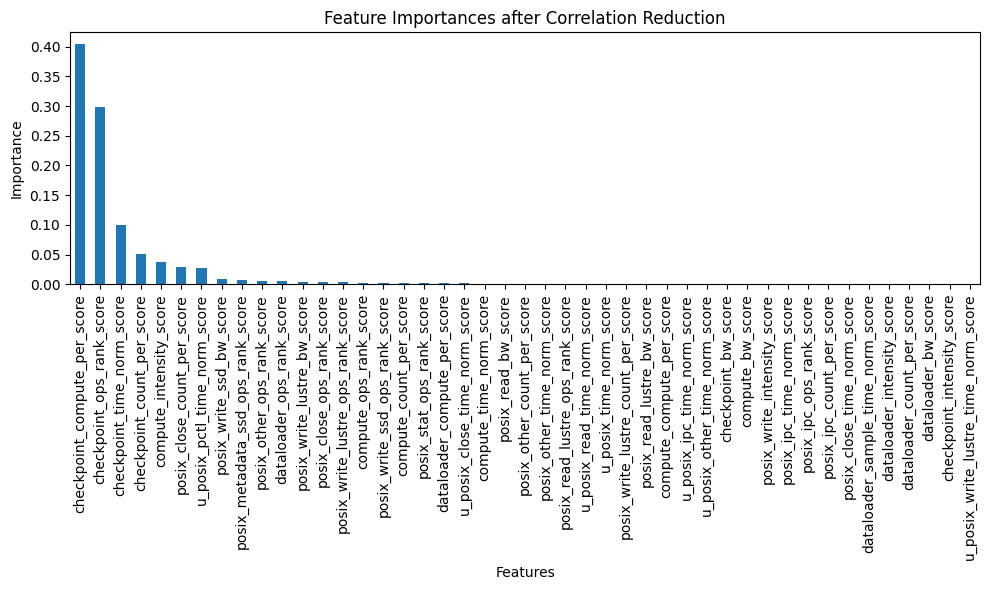

time: 12.3 s (started: 2024-12-12 19:24:01 -08:00)


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import spearmanr

def reduce_correlated_features(df, correlation_threshold=0.85, verbose=True):
    # Function to get features from a specific prefix
    def get_category_features(prefix):
        return [col for col in df.columns if col.startswith(prefix) and col.endswith('_score') and 'time_per' not in col and 'slope' not in col]
    
    # Categories to process
    categories = ['checkpoint_', 'dataloader_', 'posix_', 'compute_', 'u_posix_']
    
    # Store reduced features
    reduced_features = []
    
    for category in categories:
        cat_features = get_category_features(category)
        
        if len(cat_features) <= 1:
            reduced_features.extend(cat_features)
            continue
        
        # Compute correlation matrix for category
        cat_corr_matrix = df[cat_features].corr(method='spearman')
        
        # Visualization of correlation matrix (optional)
        if verbose:
            plt.figure(figsize=(10, 8))
            sns.heatmap(cat_corr_matrix, annot=True, cmap='coolwarm', center=0)
            plt.title(f'Correlation Matrix for {category} Features')
            plt.tight_layout()
            plt.show()
        
        # Find features to drop
        features_to_drop = set()
        for i in range(len(cat_features)):
            for j in range(i+1, len(cat_features)):
                if abs(cat_corr_matrix.iloc[i, j]) > correlation_threshold:
                    # Compare variance and keep higher variance feature
                    var_i = df[cat_features[i]].var()
                    var_j = df[cat_features[j]].var()
                    
                    if var_i >= var_j:
                        features_to_drop.add(cat_features[j])
                    else:
                        features_to_drop.add(cat_features[i])
        
        # Keep features not in drop list
        cat_reduced_features = [f for f in cat_features if f not in features_to_drop]
        reduced_features.extend(cat_reduced_features)
        
        if verbose:
            print(f"\n{category} Category:")
            print("Original features:", cat_features)
            print("Reduced features:", cat_reduced_features)
            print("Dropped features:", features_to_drop)
    
    return reduced_features

# Usage
df = pd.read_csv('dlio_scr_step100_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'

# Get reduced feature set
reduced_score_cols = reduce_correlated_features(df)

# Prepare data for Random Forest
X = df[reduced_score_cols]
y = df[target].fillna(0)

# Proceed with Random Forest as before
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nReduced Feature Importances:")
print(feature_importances)

# Optional: Visualize reduced feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances after Correlation Reduction')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
pd.read_csv('dlio_scr_opt_step100_time_range.csv').copy().set_index('time_range').sort_index().query('checkpoint_compute_per_score > 0')[['checkpoint_time', 'compute_time', 'checkpoint_compute_per', 'checkpoint_compute_per_score']]

checkpoint_time  compute_time  checkpoint_compute_per  \
time_range                                                          
6                 40.496312     24.424627                1.658011   
10                41.512489     34.194506                1.214010   
14                38.508402     58.619183                0.656925   
19                24.568133     39.079433                0.628672   
23                30.386909     34.194537                0.888648   
27                24.393385     41.521908                0.587482   
31                26.059269     51.291759                0.508060   
35                39.269755     63.504079                0.618382   
40                35.795569     29.309590                1.221292   
44                33.112518     41.521911                0.797471   
48                25.268418     61.061606                0.413818   
53                29.910187     34.194514                0.874707   
57                27.932309     36.636990                0.762407   
61                35.398564     31.752068                1.114843   
65                33.034901     53.734234                0.614783   
70                25.141352     39.079425                0.643340   
74                33.522978     29.309561                1.143756   
78                25.693526     39.079439                0.657469   
82                25.352862     43.964362                0.576668   
86                31.524712     53.734249                0.586678   
91                35.421290     31.752036                1.115560   
95                35.055275     29.309591                1.196034   
99                25.890745     46.406830                0.557908   
103               24.353686     56.176667                0.433520   
108               29.222761     34.194487                0.854604   
112               24.874298     39.079444                0.636506   
116               24.477628     39.079408                0.626356   
120               24.200931     41.521905                0.582847   
124               27.184320     43.964353                0.618326   
128               32.804240     53.734204                0.610491   

            checkpoint_compute_per_score  
time_range                                
6                                    8.0  
10                                   8.0  
14                                   6.0  
19                                   6.0  
23                                   7.0  
27                                   6.0  
31                                   6.0  
35                                   6.0  
40                                   8.0  
44                                   7.0  
48                                   5.0  
53                                   7.0  
57                                   7.0  
61                                   8.0  
65                                   6.0  
70                                   6.0  
74                                   8.0  
78                                   6.0  
82                                   6.0  
86                                   6.0  
91                                   8.0  
95                                   8.0  
99                                   6.0  
103                                  5.0  
108                                  7.0  
112                                  6.0  
116                                  6.0  
120                                  6.0  
124                                  6.0  
128                                  6.0

time: 88.7 ms (started: 2024-12-09 14:01:48 -08:00)


In [24]:
pd.read_csv('dlio_scr_opt_step100_time_range.csv').copy().set_index('time_range').sort_index().query('checkpoint_compute_per_score == checkpoint_compute_per_score.max()')[['checkpoint_time', 'checkpoint_compute_per_score']]

checkpoint_time  checkpoint_compute_per_score
time_range                                               
6                 40.496312                           8.0
10                41.512489                           8.0
40                35.795569                           8.0
61                35.398564                           8.0
74                33.522978                           8.0
91                35.421290                           8.0
95                35.055275                           8.0

time: 89.7 ms (started: 2024-12-09 14:08:24 -08:00)


In [33]:
pd.read_csv('dlio_scr_opt_step100_time_range.csv').copy().set_index('time_range').sort_index().query('posix_bw_score > 0')[['posix_size', 'posix_count', 'posix_time', 'posix_bw', 'posix_bw_score']]

posix_size  posix_count  posix_time      posix_bw  \
time_range                                                        
0             7378377949     14557255   15.785375  4.674186e+08   
1              124768957       581525    5.961267  2.092994e+07   
2             7799251712      4872576    2.660447  2.931557e+09   
3                 183168       207360    0.001108  1.653141e+08   
4                 176384       199680    0.001269  1.389945e+08   
...                  ...          ...         ...           ...   
125              5477099       190559    2.313159  2.367800e+06   
126               183168       207360    0.001234  1.484344e+08   
127               183168       207360    0.001129  1.622391e+08   
128         691608039184       173484   24.764367  2.792755e+10   
129          45458320408        64286   22.900466  1.985039e+09   

            posix_bw_score  
time_range                  
0                        4  
1                        3  
2                        5  
3                        3  
4                        3  
...                    ...  
125                      2  
126                      3  
127                      3  
128                      6  
129                      5  

[130 rows x 5 columns]

time: 88.1 ms (started: 2024-12-09 14:10:40 -08:00)


In [35]:
proc_name_view = pd.read_csv('dlio_scr_opt_step100_proc_name.csv').copy().set_index('proc_name').sort_index()
proc_name_view

checkpoint_bw  checkpoint_bw_score  \
proc_name                                                           
app#corona188#1995927#1995927            0.0                  0.0   
app#corona188#1995927#1996078            NaN                  NaN   
app#corona188#1995927#1996092            NaN                  NaN   
app#corona188#1995927#1996100            NaN                  NaN   
app#corona188#1995927#1996108            NaN                  NaN   
...                                      ...                  ...   
app#corona233#2864518#2867798            NaN                  NaN   
app#corona233#2864518#2867807            NaN                  NaN   
app#corona233#2864518#2867814            NaN                  NaN   
app#corona233#2864518#2867822            NaN                  NaN   
app#corona233#2864518#2867830            NaN                  NaN   

                               checkpoint_compute_per  \
proc_name                                               
app#corona188#1995927#1995927                0.132108   
app#corona188#1995927#1996078                     NaN   
app#corona188#1995927#1996092                     NaN   
app#corona188#1995927#1996100                     NaN   
app#corona188#1995927#1996108                     NaN   
...                                               ...   
app#corona233#2864518#2867798                     NaN   
app#corona233#2864518#2867807                     NaN   
app#corona233#2864518#2867814                     NaN   
app#corona233#2864518#2867822                     NaN   
app#corona233#2864518#2867830                     NaN   

                               checkpoint_compute_per_score  checkpoint_count  \
proc_name                                                                       
app#corona188#1995927#1995927                           4.0              41.0   
app#corona188#1995927#1996078                           NaN               NaN   
app#corona188#1995927#1996092                           NaN               NaN   
app#corona188#1995927#1996100                           NaN               NaN   
app#corona188#1995927#1996108                           NaN               NaN   
...                                                     ...               ...   
app#corona233#2864518#2867798                           NaN               NaN   
app#corona233#2864518#2867807                           NaN               NaN   
app#corona233#2864518#2867814                           NaN               NaN   
app#corona233#2864518#2867822                           NaN               NaN   
app#corona233#2864518#2867830                           NaN               NaN   

                               checkpoint_count_per  \
proc_name                                             
app#corona188#1995927#1995927              0.007812   
app#corona188#1995927#1996078                   NaN   
app#corona188#1995927#1996092                   NaN   
app#corona188#1995927#1996100                   NaN   
app#corona188#1995927#1996108                   NaN   
...                                             ...   
app#corona233#2864518#2867798                   NaN   
app#corona233#2864518#2867807                   NaN   
app#corona233#2864518#2867814                   NaN   
app#corona233#2864518#2867822                   NaN   
app#corona233#2864518#2867830                   NaN   

                               checkpoint_count_per_score  \
proc_name                                                   
app#corona188#1995927#1995927                         2.0   
app#corona188#1995927#1996078                         NaN   
app#corona188#1995927#1996092                         NaN   
app#corona188#1995927#1996100                         NaN   
app#corona188#1995927#1996108                         NaN   
...                                                   ...   
app#corona233#2864518#2867798                         NaN   
app#corona233#2864518#2867807                         NaN   
app#corona2

time: 123 ms (started: 2024-12-09 12:27:23 -08:00)


In [40]:
pd.read_csv('dlio_scr_opt_step100_proc_name.csv').copy().set_index('proc_name').sort_index().query('posix_bw_score == posix_bw_score.max()')[['posix_size', 'posix_count', 'posix_time', 'posix_bw', 'posix_bw_score']]

posix_size  posix_count  posix_time  \
proc_name                                                              
app#corona188#1995927#1995927  180624646121       136790  398.270821   
app#corona188#1995928#1995928  180624545266       135344  400.862616   
app#corona188#1995929#1995929  180624545282       135348  401.259926   
app#corona188#1995930#1995930  180624545239       135347  397.887211   
app#corona188#1995932#1995932  180624545839       135351  402.073830   
...                                     ...          ...         ...   
app#corona233#2864510#2864510  178657151770       134807  389.084221   
app#corona233#2864511#2864511  178657151630       134806  388.914269   
app#corona233#2864513#2864513  178657151683       134809  397.714031   
app#corona233#2864517#2864517  178657151667       134811  390.007490   
app#corona233#2864518#2864518  178657151728       134809  398.275222   

                                   posix_bw  posix_bw_score  
proc_name                                                    
app#corona188#1995927#1995927  4.535222e+08               5  
app#corona188#1995928#1995928  4.505896e+08               5  
app#corona188#1995929#1995929  4.501435e+08               5  
app#corona188#1995930#1995930  4.539592e+08               5  
app#corona188#1995932#1995932  4.492323e+08               5  
...                                     ...             ...  
app#corona233#2864510#2864510  4.591735e+08               5  
app#corona233#2864511#2864511  4.593741e+08               5  
app#corona233#2864513#2864513  4.492101e+08               5  
app#corona233#2864517#2864517  4.580865e+08               5  
app#corona233#2864518#2864518  4.485771e+08               5  

[112 rows x 5 columns]

time: 180 ms (started: 2024-12-09 12:43:00 -08:00)


In [32]:
import dask.dataframe as dd

def compute_time_boundaries(view: dd.DataFrame, view_type: str):
    time_cols = [col for col in view.columns if col.endswith('time')]
    view_types = view.index.names
    if view_type not in view_types:
        raise ValueError(f"Cannot compute time boundary for view type: {view_type}")
    if len(view_types) == 1 and view_type in view_types:
        if view_type == 'proc_name':
            return view[time_cols].max()
        return view[time_cols].sum()
    elif 'proc_name' in view_types:
        return view[time_cols].groupby(view_type).max().sum()
    return view[time_cols].groupby(view_type).sum()

time: 1.27 ms (started: 2024-12-01 21:35:31 -08:00)


In [35]:
compute_time_boundaries(flat_views[('time_range',)], view_type='time_range')[
    [
        'checkpoint_time',
        'compute_time',
        'dataloader_time',
        'dlio_time',
        'posix_time',
        'reader_time',
    ]
].sum()

18644.487236

time: 7.18 ms (started: 2024-12-01 21:38:42 -08:00)


In [ ]:
 App Time  Runtime: 8428.34 seconds (100%)                                                                      │
│            ├── Application I/O Time: 1487.00 seconds (17.64%)                                                   │
│            ├── Checkpoint I/O Time: 1485.76 seconds (17.63%)                                                    │
│            ├── Compute Time: 7327.39 seconds (86.94%)                                                           │
│            ├── I/O Time: 938.97 seconds (11.14%)                                                                │
│            ├── Read I/O Time: 1.69 seconds (0.02%)                                                              │
│            ├── Time: 18436.94 seconds (218.75%)                                                                 │
│            ├── Unoverlapped Application I/O Time: 297.31 seconds (3.53%)                                        │
│            ├── Unoverlapped Checkpoint I/O Time: 297.31 seconds (3.53%)                                         │
│            ├── Unoverlapped Compute Time: 6469.93 seconds (76.76%)                                              │
│            ├── Unoverlapped I/O Time: 81.50 seconds (0.97%)                                                     │
│            ├── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│            └── Unoverlapped Application Compute Time: 6137.71 seconds (72.82%)

In [37]:
import dask 

dask.compute(metric_boundaries)

({'dlio': {'proc_name': {'intensity': None,
    'io_compute_per': None,
    'ops': 13173.219933,
    'time_norm': 13173.219933,
    'time_per': 13173.219933},
   'time_range': {'intensity': None,
    'io_compute_per': None,
    'ops': 8253.385782000001,
    'time_norm': 8253.385782000001,
    'time_per': 8253.385782000001}},
  'compute': {'proc_name': {'intensity': None,
    'io_compute_per': None,
    'ops': 8440.924997999999,
    'time_norm': 8440.924997999999,
    'time_per': 8440.924997999999},
   'time_range': {'intensity': None,
    'io_compute_per': None,
    'ops': 7327.394178,
    'time_norm': 7327.394178,
    'time_per': 7327.394178}},
  <Layer.DATALOADER: 'DATALOADER'>: {'proc_name': {'intensity': None,
    'ops': 22691.899601999998,
    'time_norm': 22691.899601999998,
    'time_per': 22691.899601999998},
   'time_range': {'intensity': None,
    'ops': 33.677771,
    'time_norm': 33.677771,
    'time_per': 33.677771}},
  'checkpoint': {'proc_name': {'intensity': None,
    '

time: 12.4 ms (started: 2024-12-01 21:39:11 -08:00)


In [11]:
for layer in result.bottlenecks:
    for view_key in result.bottlenecks[layer]:
        if len(view_key) == 1 and view_key[0] == 'proc_name':
            for metric in result.bottlenecks[layer][view_key]:
                bottlenecks = result.bottlenecks[layer][view_key][metric]
                print(layer, view_key, metric, len(bottlenecks))

APP ('proc_name',) intensity 3
APP ('proc_name',) io_compute_per 0
APP ('proc_name',) io_bw 1664
APP ('proc_name',) io_time_norm 0
APP ('proc_name',) io_time_per 0
APP ('proc_name',) ops 231
APP ('proc_name',) time_norm 0
APP ('proc_name',) time_per 0
APP ('proc_name',) u_io_time_per 1408
DATALOADER ('proc_name',) intensity 0
DATALOADER ('proc_name',) io_bw 1664
DATALOADER ('proc_name',) io_time_norm 0
DATALOADER ('proc_name',) io_time_per 0
DATALOADER ('proc_name',) ops 231
DATALOADER ('proc_name',) time_norm 0
DATALOADER ('proc_name',) time_per 0
POSIX ('proc_name',) intensity 0
POSIX ('proc_name',) io_bw 1664
POSIX ('proc_name',) io_time_norm 0
POSIX ('proc_name',) io_time_per 0
POSIX ('proc_name',) ops 231
POSIX ('proc_name',) time_norm 0
POSIX ('proc_name',) time_per 0
time: 927 ms (started: 2024-11-25 21:31:58 -08:00)


In [13]:
result.main_views['APP'].reset_index()['time_range'].nunique().compute()

130

time: 304 ms (started: 2024-11-25 18:29:34 -08:00)


In [14]:
result.main_views['APP'].reset_index()['proc_name'].nunique().compute()

2304

time: 318 ms (started: 2024-11-25 18:29:38 -08:00)


In [15]:
result.bottlenecks['APP'][('proc_name',)]['ops']['behavior'].value_counts().compute()

behavior
 2    450
 0     98
 1     21
 3      7
-1      1
Name: count, dtype: int64

time: 29.1 ms (started: 2024-11-25 18:29:52 -08:00)


In [16]:
result.bottlenecks['APP'][('proc_name',)]['ops'].select_dtypes(['number']).groupby('behavior').mean().compute()

app_io_time  checkpoint_io_time  compute_time     io_time  \
behavior                                                              
-1        1139.607395         1139.607395   7327.136438  696.392549   
 0        1428.702364         1428.702364   7327.170392  399.134927   
 1        1275.960221         1275.960221   7327.099428  556.813675   
 2                0.0            0.000000           0.0     0.13322   
 3        1139.598286         1139.598286    7326.70733  696.211446   

          read_io_time          time          count  size_min  \
behavior                                                        
-1                 0.0  17563.607268  144869.000000       0.0   
 0                 0.0  17947.668053  147466.132653       0.0   
 1                 0.0  18105.410418  147894.476190       0.0   
 2                 0.0       0.13322       1.000000       0.0   
 3                 0.0  17563.129086  144015.000000       0.0   

                   size_max                 size  ...  io_compute_per_score  \
behavior                                          ...                         
-1             1009258513.0        69164951322.0  ...              0.285714   
 0        1875130651.857143  179785981608.377563  ...              0.285714   
 1             1875130518.0  179317571228.476196  ...              0.340136   
 2                      0.0                  0.0  ...              0.000000   
 3             1009258513.0   69197173404.857147  ...              0.285714   

          io_time_norm_score  io_time_per_score  ops_rank_score  \
behavior                                                          
-1                  0.428571           0.285714        0.857143   
 0                  0.285714           0.142857        0.857143   
 1                  0.340136           0.197279        0.911565   
 2                  0.000000           0.000000        0.927619   
 3                  0.428571           0.285714        0.857143   

          time_norm_score  time_per_score  u_io_time_per_score  n_proc_name  \
behavior                                                                      
-1               0.571429        0.142857                  0.0          1.0   
 0               0.714286        0.142857                  0.0          1.0   
 1               0.714286        0.142857                  0.0          1.0   
 2               0.000000        0.000000                  1.0          1.0   
 3               0.571429        0.142857                  0.0          1.0   

          n_time_range  n_step  
behavior                        
-1               130.0  3001.0  
 0               130.0  3001.0  
 1               130.0  3001.0  
 2                 1.0     1.0  
 3               130.0  3001.0  

[5 rows x 97 columns]

time: 224 ms (started: 2024-11-25 18:30:01 -08:00)


In [17]:
posix_proc_name_ops = result.bottlenecks['POSIX'][('proc_name',)]['ops']
posix_proc_name_ops_grouped = posix_proc_name_ops[posix_proc_name_ops['behavior'] != -1].compute()
posix_proc_name_ops_outliers = posix_proc_name_ops[posix_proc_name_ops['behavior'] == -1].set_index('behavior').compute()
posix_proc_name_ops_outliers['behavior_count'] = 1
posix_proc_name_ops_outliers.head()

step  app_io_time  checkpoint_io_time  compute_time     io_time  \
behavior                                                                    
-1           0          0.0                 0.0           0.0  696.392549   

          read_io_time        time   count  size_min    size_max  ...  \
behavior                                                          ...   
-1                 0.0  696.392549  132717         0  1009255610  ...   

          b_size_imbalance  b_size_imbalance_0  b_size_imbalance_1  \
behavior                                                             
-1                    True               False                True   

          b_small_reads  b_small_reads_0  b_small_reads_1  b_small_writes  \
behavior                                                                    
-1                False            False             True            True   

          b_small_writes_0  b_small_writes_1  behavior_count  
behavior                                                      
-1                    True              True               1  

[1 rows x 113 columns]

time: 237 ms (started: 2024-11-25 18:31:14 -08:00)


In [18]:
posix_proc_name_ops_beh_count = posix_proc_name_ops_grouped['behavior'].value_counts()
posix_proc_name_ops_beh_count.name = 'behavior_count'
posix_proc_name_ops_beh_count

behavior
2    540
0     17
3      7
4      7
1      5
Name: behavior_count, dtype: int64

time: 4.27 ms (started: 2024-11-25 18:31:20 -08:00)


In [20]:
import pandas as pd

pd.concat(
    [
        posix_proc_name_ops_grouped.select_dtypes(['number'])
        .groupby('behavior')
        .mean()
        .merge(posix_proc_name_ops_beh_count, left_index=True, right_index=True),
        posix_proc_name_ops_outliers.select_dtypes(['number']),
    ]
).sort_values('behavior_count', ascending=False)

step  app_io_time  checkpoint_io_time  compute_time     io_time  \
behavior                                                                    
 2         0.0          0.0                 0.0           0.0    0.125279   
 0         0.0          0.0                 0.0           0.0  409.764625   
 3         0.0          0.0                 0.0           0.0  696.211446   
 4         0.0          0.0                 0.0           0.0  805.853531   
 1         0.0          0.0                 0.0           0.0  496.064889   
-1         0.0          0.0                 0.0           0.0  696.392549   

          read_io_time        time          count  size_min  \
behavior                                                      
 2                 0.0    0.125279       1.103704       0.0   
 0                 0.0  409.764625  135252.764706       0.0   
 3                 0.0  696.211446  131863.000000       0.0   
 4                 0.0  805.853531  134808.571429       0.0   
 1                 0.0  496.064889  136085.800000       0.0   
-1                 0.0  696.392549  132717.000000       0.0   

                   size_max  ...  time_per  intensity_rank_score  \
behavior                     ...                                   
 2                      0.0  ...  0.000002              0.428571   
 0        1875127893.647059  ...   0.00695              0.571429   
 3             1009255610.0  ...  0.011809              0.571429   
 4             1875127431.0  ...  0.013668              0.571429   
 1             1875127878.4  ...  0.008414              0.571429   
-1             1009255610.0  ...  0.011812              0.571429   

          io_time_norm_score  io_time_per_score  ops_rank_score  \
behavior                                                          
 2                  0.000000           0.000000        0.917989   
 0                  0.285714           0.142857        0.857143   
 3                  0.428571           0.285714        0.857143   
 4                  0.428571           0.285714        0.857143   
 1                  0.314286           0.171429        0.857143   
-1                  0.428571           0.285714        0.857143   

          time_norm_score  time_per_score  n_proc_name  n_time_range  \
behavior                                                               
 2               0.000000        0.000000          1.0           1.0   
 0               0.285714        0.142857          1.0         130.0   
 3               0.428571        0.285714          1.0         130.0   
 4               0.428571        0.285714          1.0         130.0   
 1               0.314286        0.171429          1.0         130.0   
-1               0.428571        0.285714          1.0         130.0   

          behavior_count  
behavior                  
 2                   540  
 0                    17  
 3                     7  
 4                     7  
 1                     5  
-1                     1  

[6 rows x 94 columns]

time: 35.5 ms (started: 2024-11-25 18:31:38 -08:00)


In [21]:
result.bottlenecks['APP'][('proc_name',)]['u_io_time_per']['behavior'].value_counts().compute()

behavior
0    768
1    512
2    128
Name: count, dtype: int64

time: 32.4 ms (started: 2024-11-25 18:32:34 -08:00)


In [22]:
result.bottlenecks['APP'][('proc_name',)]['u_io_time_per'].select_dtypes(['number']).groupby('behavior').mean().compute()

app_io_time  checkpoint_io_time  compute_time   io_time  \
behavior                                                            
0                 0.0                 0.0           0.0  1.700928   
1                 0.0                 0.0           0.0   0.13163   
2                 0.0                 0.0           0.0  0.008585   

          read_io_time      time   count  size_min  size_max        size  ...  \
behavior                                                                  ...   
0                  0.0  1.700928  6707.0       0.0  283831.0  10129743.0  ...   
1                  0.0   0.13163     1.0       0.0       0.0         0.0  ...   
2                  0.0  0.008585     3.0       0.0       0.0         0.0  ...   

          io_compute_per_score  io_time_norm_score  io_time_per_score  \
behavior                                                                
0                          0.0                 0.0                0.0   
1                          0.0                 0.0                0.0   
2                          0.0                 0.0                0.0   

          ops_rank_score  time_norm_score  time_per_score  \
behavior                                                    
0               0.416853              0.0             0.0   
1               0.901786              0.0             0.0   
2               0.714286              0.0             0.0   

          u_io_time_per_score  n_proc_name  n_time_range  n_step  
behavior                                                          
0                         1.0          1.0         127.0     1.0  
1                         1.0          1.0           1.0     1.0  
2                         1.0          1.0           1.0     1.0  

[3 rows x 97 columns]

time: 196 ms (started: 2024-11-25 18:32:39 -08:00)


In [24]:
result.bottlenecks['APP'][('time_range',)]['u_io_time_per']['behavior'].value_counts().compute()

behavior
-1    1
Name: count, dtype: int64

time: 45 ms (started: 2024-11-25 18:33:07 -08:00)


In [9]:
analyzer.write_bottlenecks(result.flat_bottlenecks)

time: 3.36 s (started: 2024-11-25 18:28:49 -08:00)


In [10]:
bottlenecks = analyzer.read_bottlenecks()
bottlenecks.compute()

subject  app_io_time  checkpoint_io_time  \
0   app#corona188#1995927#1996131     1.948441                 0.0   
1   app#corona188#1995927#1996698     1.934243                 0.0   
2   app#corona188#1995927#1997139     1.953941                 0.0   
3   app#corona188#1995927#1997706     1.913874                 0.0   
4   app#corona188#1995927#1998211     1.965713                 0.0   
..                            ...          ...                 ...   
32  app#corona232#2812441#2812441          0.0                 0.0   
33  app#corona232#2812444#2812444          0.0                 0.0   
34  app#corona232#2812447#2812447          0.0                 0.0   
35  app#corona232#2812448#2812448          0.0                 0.0   
36  app#corona221#2253262#2253262          0.0                 0.0   

    compute_time     io_time  read_io_time        time   count  size_min  \
0            0.0    0.338853      1.293963    34.79085   51589         0   
1            0.0    1.052536      1.292620   35.648734   51589         0   
2            0.0    0.921307      1.306269    35.37777   51589         0   
3            0.0    1.247417      1.274207   35.242778   51589         0   
4            0.0    1.338769      1.301382   35.374518   51589         0   
..           ...         ...           ...         ...     ...       ...   
32           0.0   807.58686      0.000000   807.58686  134808         0   
33           0.0  804.065177      0.000000  804.065177  134811         0   
34           0.0  799.976272      0.000000  799.976272  134811         0   
35           0.0   807.35153      0.000000   807.35153  134806         0   
36           0.0  408.792457      0.000000  408.792457  135351         0   

      size_max  ...  b_small_writes_0  b_small_writes_1  b_unoverlapped_io  \
0        65536  ...             False              True              False   
1        65536  ...             False              True              False   
2        65536  ...             False              True              False   
3        65536  ...             False              True              False   
4        65536  ...             False              True              False   
..         ...  ...               ...               ...                ...   
32  1875127431  ...              True             False               <NA>   
33  1875127431  ...              True             False               <NA>   
34  1875127431  ...              True             False               <NA>   
35  1875127431  ...              True             False               <NA>   
36  1875127992  ...              True             False               <NA>   

    b_unoverlapped_io_0  behavior  layer     metric  view_depth  \
0                 False         0    APP  intensity           1   
1                 False         0    APP  intensity           1   
2                 False         0    APP  intensity           1   
3                 False         0    APP  intensity           1   
4                 False         0    APP  intensity           1   
..                  ...       ...    ...        ...         ...   
32                 <NA>         2  POSIX        ops           2   
33                 <NA>         2  POSIX        ops           2   
34                 <NA>         2  POSIX        ops           2   
35                 <NA>         2  POSIX        ops           2   
36                 <NA>         0  POSIX        ops           2   

               view_name  step  
0              proc_name  <NA>  
1              proc_name  <NA>  
2              proc_name  <NA>  
3              proc_name  <NA>  
4              proc_name  <NA>  
..                   ...   ...  
32  time_range.proc_name     0  
33  time_range.proc_name     0  
34  time_range.proc_name     0  
35  time_range.proc_name     0  
36  time_range.proc_name     0  

[27775 rows x 125 columns]

time: 1.29 s (started: 2024-11-25 18:28:54 -08:00)


In [11]:
bottleneck_rules = list(result.bottleneck_rules.keys())
bottleneck_cols = [f"b_{rule}" for rule in bottleneck_rules]
bottleneck_cols

['b_excessive_metadata_access',
 'b_operation_imbalance',
 'b_random_operations',
 'b_size_imbalance',
 'b_small_reads',
 'b_small_writes',
 'b_unoverlapped_io']

time: 4.02 ms (started: 2024-11-09 10:42:56 -08:00)


In [12]:
plot_df = result.flat_bottlenecks.groupby(['layer', 'view_name'])[bottleneck_cols].sum().compute()
plot_df

b_excessive_metadata_access  \
layer      view_name                                           
APP        proc_name                                    2125   
           time_range                                      0   
           proc_name.time_range                            0   
           time_range.proc_name                           77   
DATALOADER proc_name                                     717   
           time_range                                     11   
           proc_name.time_range                           11   
           time_range.proc_name                          717   
POSIX      proc_name                                    1485   
           time_range                                     12   
           proc_name.time_range                           12   
           time_range.proc_name                         1485   

                                 b_operation_imbalance  b_random_operations  \
layer      view_name                                                          
APP        proc_name                               845                    0   
           time_range                                0                    0   
           proc_name.time_range                      0                    0   
           time_range.proc_name                     77                    0   
DATALOADER proc_name                                77                    0   
           time_range                                2                    0   
           proc_name.time_range                      2                    0   
           time_range.proc_name                     77                    0   
POSIX      proc_name                               768                    0   
           time_range                                2                    0   
           proc_name.time_range                      2                    0   
           time_range.proc_name                    768                    0   

                                 b_size_imbalance  b_small_reads  \
layer      view_name                                               
APP        proc_name                         1101              0   
           time_range                          77              0   
           proc_name.time_range                43              0   
           time_range.proc_name               205              0   
DATALOADER proc_name                         1101              0   
           time_range                          92              0   
           proc_name.time_range                92              0   
           time_range.proc_name               973              0   
POSIX      proc_name                         1101              0   
           time_range                          92              0   
           proc_name.time_range                92              0   
           time_range.proc_name               973              0   

                                 b_small_writes  b_unoverlapped_io  
layer      view_name                                                
APP        proc_name                          0               2125  
           time_range                         3                  3  
           proc_name.time_range               1                  1  
           time_range.proc_name               0                 77  
DATALOADER proc_name                         16                  0  
           time_range                         4                  0  
           proc_name.time_range               4                  0  
           time_range.proc_name               8                  0  
POSIX      proc_name                         16                  0  
           time_range                         4                  0  
           proc_name.time_range               4                  0  
           time_range.proc_name               8                  0

time: 330 ms (started: 2024-11-09 10:42:59 -08:00)


<Axes: xlabel='layer,view_name'>

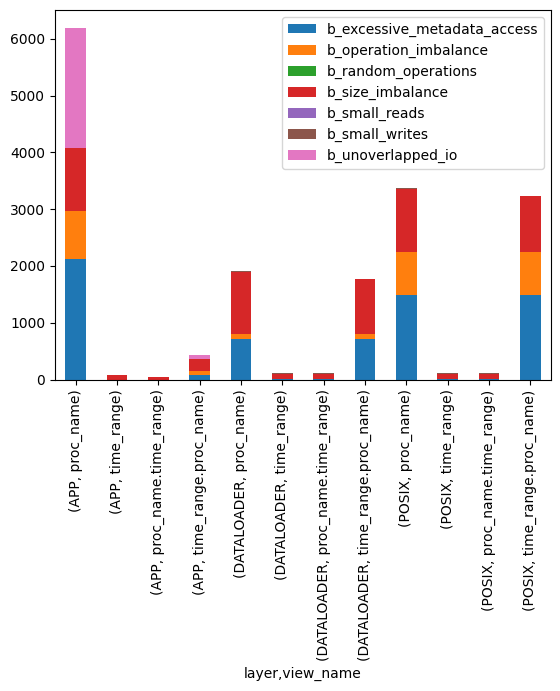

time: 2.39 s (started: 2024-11-09 10:43:05 -08:00)


In [13]:
plot_df.plot.bar(stacked=True)

In [23]:
result.main_views['DATALOADER'].query('time_range == 1').head()

app_io_time  checkpoint_io_time  \
proc_name                     time_range                                    
app#corona188#1995927#1995927 1                   0.0                 0.0   
app#corona188#1995927#1997706 1                   0.0                 0.0   
app#corona188#1995928#1996888 1                   0.0                 0.0   
app#corona188#1995928#1999116 1                   0.0                 0.0   
app#corona188#1995930#1996446 1                   0.0                 0.0   

                                          compute_time   io_time  \
proc_name                     time_range                           
app#corona188#1995927#1995927 1                    0.0  5.479151   
app#corona188#1995927#1997706 1                    0.0  1.035404   
app#corona188#1995928#1996888 1                    0.0  0.974567   
app#corona188#1995928#1999116 1                    0.0  1.130497   
app#corona188#1995930#1996446 1                    0.0  0.191372   

                                          read_io_time       time  count  \
proc_name                     time_range                                   
app#corona188#1995927#1995927 1                    0.0  36.501288   4167   
app#corona188#1995927#1997706 1                    0.0  25.227881     71   
app#corona188#1995928#1996888 1                    0.0  25.814204     71   
app#corona188#1995928#1999116 1                    0.0   24.71177     71   
app#corona188#1995930#1996446 1                    0.0  24.819001     71   

                                          size_min  size_max    size  ...  \
proc_name                     time_range                              ...   
app#corona188#1995927#1995927 1                 48     11759  111304  ...   
app#corona188#1995927#1997706 1                365     65536  141033  ...   
app#corona188#1995928#1996888 1                365     65536  141033  ...   
app#corona188#1995928#1999116 1                365     65536  141033  ...   
app#corona188#1995930#1996446 1                365     65536  141033  ...   

                                          u_metadata_time  u_data_time  \
proc_name                     time_range                                 
app#corona188#1995927#1995927 1                  5.386636     0.087944   
app#corona188#1995927#1997706 1                  1.035301     0.000103   
app#corona188#1995928#1996888 1                  0.974463     0.000104   
app#corona188#1995928#1999116 1                  1.130397     0.000100   
app#corona188#1995930#1996446 1                  0.181103     0.010269   

                                          u_sequential_time  u_random_time  \
proc_name                     time_range                                     
app#corona188#1995927#1995927 1                    0.087944            0.0   
app#corona188#1995927#1997706 1                    0.000103            0.0   
app#corona188#1995928#1996888 1                    0.000104            0.0   
app#corona188#1995928#1999116 1                    0.000100            0.0   
app#corona188#1995930#1996446 1                    0.010269            0.0   

                                          u_close_time  u_open_time  \
proc_name                     time_range                              
app#corona188#1995927#1995927 1               0.003048     0.039210   
app#corona188#1995927#1997706 1               0.000029     0.021934   
app#corona188#1995928#1996888 1               0.000028     0.007924   
app#corona188#1995928#1999116 1               0.000023     0.016216   
app#corona188#1995930#1996446 1               0.000039     0.018246   

                                          u_seek_time  u_stat_time  \
proc_name                     time_range                             
app#corona188#1995927#1995927 1              0.000019     0.018506   
app#corona188#1995927#1997706 1              0.000007     0.000321   
app#corona188#1995928#1996888 1              0.000011     0.000331   
app#corona188#1995928#1999116 1       

time: 333 ms (started: 2024-11-09 11:40:39 -08:00)


In [34]:
bot_dl_tr = result.flat_bottlenecks.query('layer == "DATALOADER" & view_name == "time_range"').compute()
bot_dl_tr[['subject', 'metric', 'time', 'io_time', 'count', 'ops_score', 'time_score'] + bottleneck_cols].sort_values('subject')

subject metric       time    io_time     count  ops_score time_score  \
91       0   iops  15.785375  15.785375  14557255       high   very low   
0        1   iops  37.855383   5.961267    582933       high   very low   
74      10   iops  34.149186  34.149186    149800   critical   very low   
9      100   iops   3.569055   3.569055    240287       high    trivial   
81     103   iops   21.05796   21.05796    228222  very high   very low   
..     ...    ...        ...        ...       ...        ...        ...   
39      94   iops   0.014987   0.001119    252928     medium       none   
8       95   iops  32.812665  32.812665    137153   critical   very low   
80      97   iops   0.016503   0.001105    262656     medium       none   
27      98   iops   0.017476   0.001188    252928       high       none   
86      99   iops  21.118441  21.118441    198429  very high   very low   

   b_excessive_metadata_access  b_operation_imbalance  b_random_operations  \
91                        True                  False                False   
0                        False                   True                False   
74                       False                  False                False   
9                         True                  False                False   
81                       False                  False                False   
..                         ...                    ...                  ...   
39                       False                  False                False   
8                        False                  False                False   
80                       False                  False                False   
27                       False                  False                False   
86                       False                  False                False   

   b_size_imbalance b_small_reads b_small_writes b_unoverlapped_io  
91             True         False          False              <NA>  
0              True         False          False              <NA>  
74             True         False          False              <NA>  
9              True         False          False              <NA>  
81             True         False          False              <NA>  
..              ...           ...            ...               ...  
39             True         False          False              <NA>  
8              True         False          False              <NA>  
80             True         False          False              <NA>  
27             True         False          False              <NA>  
86             True         False          False              <NA>  

[92 rows x 14 columns]

time: 940 ms (started: 2024-11-09 11:54:30 -08:00)


In [35]:
bot_posix_tr = result.flat_bottlenecks.query('layer == "POSIX" & view_name == "time_range"').compute()
bot_posix_tr[['subject', 'metric', 'time', 'io_time', 'count', 'ops_score', 'time_score'] + bottleneck_cols].sort_values('subject')

subject metric       time    io_time     count  ops_score time_score  \
91       0   iops  15.785375  15.785375  14557255       high   very low   
0        1   iops   5.961267   5.961267    581525       high    trivial   
72      10   iops  34.149186  34.149186    121128   critical   very low   
8      100   iops   3.569055   3.569055    191135       high    trivial   
9      101   iops   0.001104   0.001104    199680     medium       none   
..     ...    ...        ...        ...       ...        ...        ...   
83      92   iops   0.001121   0.001121    199680       high       none   
34      94   iops   0.001119   0.001119    199680       high       none   
7       95   iops  32.812665  32.812665    112577   critical   very low   
25      98   iops   0.001188   0.001188    199680       high       none   
85      99   iops  21.118441  21.118441    159517  very high   very low   

   b_excessive_metadata_access  b_operation_imbalance  b_random_operations  \
91                        True                  False                False   
0                         True                   True                False   
72                       False                  False                False   
8                         True                  False                False   
9                        False                  False                False   
..                         ...                    ...                  ...   
83                       False                  False                False   
34                       False                  False                False   
7                        False                  False                False   
25                       False                  False                False   
85                       False                  False                False   

   b_size_imbalance b_small_reads b_small_writes b_unoverlapped_io  
91             True         False          False              <NA>  
0              True         False          False              <NA>  
72             True         False          False              <NA>  
8              True         False          False              <NA>  
9              True         False          False              <NA>  
..              ...           ...            ...               ...  
83             True         False          False              <NA>  
34             True         False          False              <NA>  
7              True         False          False              <NA>  
25             True         False          False              <NA>  
85             True         False          False              <NA>  

[92 rows x 14 columns]

time: 567 ms (started: 2024-11-09 11:54:32 -08:00)


In [9]:
output.handle_result([], result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  App Time  Runtime: 8428.34 seconds (100%)                                                                      │
│            ├── Application I/O Time: 1487.00 seconds (17.64%)                                                   │
│            ├── Checkpoint I/O Time: 1485.76 seconds (17.63%)                                                    │
│            ├── Compute Time: 7327.39 seconds (86.94%)                                                           │
│            ├── I/O Time: 938.97 seconds (11.14%)                                                                │
│            ├── Read I/O Time: 1.69 seconds (0.02%)                                                              │
│            ├── Time: 18436.94 seconds (218.75%)                                                                 │
│            ├── Unoverlapped Application I/O Time: 297.31 seconds (3.53%)                                        │
│            ├── Unoverlapped Checkpoint I/O Time: 297.31 seconds (3.53%)                                         │
│            ├── Unoverlapped Compute Time: 6469.93 seconds (76.76%)                                              │
│            ├── Unoverlapped I/O Time: 81.50 seconds (0.97%)                                                     │
│            ├── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│            └── Unoverlapped Application Compute Time: 6137.71 seconds (72.82%)                                  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  Unoverlapped I/O Time  81.50 seconds (100%)                                                                    │
│                         ├── Read: 3.27 seconds (4.02%)                                                          │
│                         ├── Write: 40.36 seconds (49.52%)                                                       │
│                         └── Metadata: 22.56 seconds (27.68%)                                                    │
│  Unoverlapped I/O Ops.  16,543,145 ops                                                                          │
│                         ├── Read - 1,224,090 ops (7.40%)                                                        │
│                         ├── Write - 73,755 ops (0.45%)                                                          │
│                         └── Metadata - 13,926,874 ops (84.19%)                                                  │
│  Unoverlapped I/O Size  4.20 TiB                                                                                │
│                         ├── Read - 6.47 GiB (0.15%)                                                             │
│                         └── Write - 4.20 TiB (99.85%)                                                           │
│  Read Requests          4 kiB->64 MiB - 1,224,090 ops                                                           │
│                         ├── 256 kiB-1 MiB - 8,726 ops (0.71%)                                                   │
│                         ├── 16-64 MiB - 177,796 ops (14.52%)                                                    │
│                         └── >64 MiB - 1,037,568 ops (8

time: 3.14 s (started: 2024-11-04 14:10:13 -08:00)


In [9]:
output.handle_result([], result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  App Time  Runtime: 8428.34 seconds (100%)                                                                      │
│            ├── Application I/O Time: 1487.00 seconds (17.64%)                                                   │
│            ├── Checkpoint I/O Time: 1485.76 seconds (17.63%)                                                    │
│            ├── Compute Time: 7327.39 seconds (86.94%)                                                           │
│            ├── I/O Time: 938.97 seconds (11.14%)                                                                │
│            ├── Read I/O Time: 1.69 seconds (0.02%)                                                              │
│            ├── Time: 18436.94 seconds (218.75%)                                                                 │
│            ├── Unoverlapped Application I/O Time: 297.31 seconds (3.53%)                                        │
│            ├── Unoverlapped Checkpoint I/O Time: 297.31 seconds (3.53%)                                         │
│            ├── Unoverlapped Compute Time: 6469.93 seconds (76.76%)                                              │
│            ├── Unoverlapped I/O Time: 81.50 seconds (0.97%)                                                     │
│            ├── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│            └── Unoverlapped Application Compute Time: 6137.71 seconds (72.82%)                                  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  I/O Time         1431.47 seconds (100%) - Unoverlapped: 81.50 seconds (5.69%)                                  │
│                   ├── Read: 3.27 seconds (0.23%) - Unoverlapped: 3.27 seconds (99.99%)                          │
│                   ├── Write: 238.12 seconds (16.63%) - Unoverlapped: 40.36 seconds (16.95%)                     │
│                   └── Metadata: 47.10 seconds (3.29%) - Unoverlapped: 22.56 seconds (47.90%)                    │
│  I/O Operations   16,543,145 ops                                                                                │
│                   ├── Read - 1,224,090 ops (7.40%)                                                              │
│                   ├── Write - 73,755 ops (0.45%)                                                                │
│                   └── Metadata - 13,926,874 ops (84.19%)                                                        │
│  I/O Size         4.20 TiB                                                                                      │
│                   ├── Read - 6.47 GiB (0.15%)                                                                   │
│                   └── Write - 4.20 TiB (99.85%)                                                                 │
│  Read Requests    4 kiB->64 MiB - 1,224,090 ops                                                                 │
│                   ├── 256 kiB-1 MiB - 8,726 ops (0.71%)                                                         │
│                   ├── 16-64 MiB - 177,796 ops (14.52%)                                                          │
│                   └── >64 MiB - 1,037,568 ops (84.76%)

time: 2.64 s (started: 2024-11-04 01:02:08 -08:00)


In [9]:
output.handle_result([], result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  App Time  Runtime: 8428.34 seconds (100%)                                                                      │
│            ├── Application I/O Time: 1487.00 seconds (17.64%)                                                   │
│            ├── Checkpoint I/O Time: 1485.76 seconds (17.63%)                                                    │
│            ├── Compute Time: 7327.39 seconds (86.94%)                                                           │
│            ├── I/O Time: 938.97 seconds (11.14%)                                                                │
│            ├── Read I/O Time: 1.69 seconds (0.02%)                                                              │
│            ├── Time: 18436.94 seconds (218.75%)                                                                 │
│            ├── Unoverlapped Application Compute Time: 6137.71 seconds (72.82%)                                  │
│            ├── Unoverlapped Compute Time: 6469.93 seconds (76.76%)                                              │
│            ├── Unoverlapped Application I/O Time: 297.31 seconds (3.53%)                                        │
│            ├── Unoverlapped I/O Time: 81.50 seconds (0.97%)                                                     │
│            ├── Unoverlapped Checkpoint I/O Time: 297.31 seconds (3.53%)                                         │
│            └── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  I/O Time         938.97 seconds (100%) - Unoverlapped: 81.50 seconds (8.68%)                                   │
│                   ├── Read: 4.15 seconds (0.44%) - Unoverlapped: 3.27 seconds (78.88%)                          │
│                   ├── Write: 841.95 seconds (89.67%) - Unoverlapped: 40.36 seconds (4.79%)                      │
│                   └── Metadata: 123.98 seconds (13.20%) - Unoverlapped: 22.56 seconds (18.20%)                  │
│  I/O Operations   43,581,671 ops                                                                                │
│                   ├── Read - 1,983,942 ops (4.55%)                                                              │
│                   ├── Write - 600,319 ops (1.38%)                                                               │
│                   └── Metadata - 20,758,464 ops (47.63%)                                                        │
│  I/O Size         20.12 TiB                                                                                     │
│                   ├── Read - 13.75 GiB (0.07%)                                                                  │
│                   └── Write - 20.11 TiB (99.93%)                                                                │
│  Read Requests    4 kiB-1 MiB - 1,983,942 ops                                                                   │
│                   ├── <4 kiB - 896 ops (0.05%)                                                                  │
│                   ├── 4-16 kiB - 186,694 ops (9.41%)                                                            │
│                   ├── 16-64 kiB - 13,824 ops (0.70%)  

time: 1.7 s (started: 2024-11-03 19:03:38 -08:00)


In [9]:
output.handle_result([], result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime   8428.34 seconds                                                                                      │
│  App Time  App Time Breakdown                                                                                   │
│            ├── Compute Time: 7327.39 seconds (86.94%)                                                           │
│            ├── I/O Time: 938.97 seconds (11.14%)                                                                │
│            ├── Application I/O Time: 1487.00 seconds (17.64%)                                                   │
│            ├── Read I/O Time: 1.69 seconds (0.02%)                                                              │
│            ├── Checkpoint I/O Time: 1485.76 seconds (17.63%)                                                    │
│            ├── Unoverlapped Application Compute Time: 6137.71 seconds (72.82%)                                  │
│            ├── Unoverlapped Application I/O Time: 297.31 seconds (3.53%)                                        │
│            ├── Unoverlapped Compute Time: 6469.93 seconds (76.76%)                                              │
│            ├── Unoverlapped I/O Time: 81.50 seconds (0.97%)                                                     │
│            ├── Unoverlapped Checkpoint I/O Time: 297.31 seconds (3.53%)                                         │
│            └── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│                                                                                                                 │
╰─ R: Read - W: Write - M: Metadata  ─────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime          8428.34 seconds                                                                               │
│  I/O Time         826.26 seconds                                                                                │
│                   ├── Read - 3.22 seconds (0.39%)                                                               │
│                   ├── Write - 710.17 seconds (85.95%)                                                           │
│                   └── Metadata - 114.08 seconds (13.81%)                                                        │
│  I/O Operations   43,581,671 ops                                                                                │
│                   ├── Read - 1,983,942 ops (4.55%)                                                              │
│                   ├── Write - 600,319 ops (1.38%)                                                               │
│                   └── Metadata - 20,758,464 ops (47.63%)                                                        │
│  I/O Size         20.12 TiB                                                                                     │
│                   ├── Read - 13.75 GiB (0.07%)                                                                  │
│                   └── Write - 20.11 TiB (99.93%)                                                                │
│  Read Requests    4 kiB-1 MiB - 1,983,942 ops                                                                   │
│                   ├── <4 kiB - 896 ops (0.05%)                                                                  │
│                   ├── 4-16 kiB - 186,694 ops (9.41%)  

time: 111 ms (started: 2024-11-02 21:57:31 -07:00)


In [9]:
import dask
import dask.dataframe as dd

dask.compute(metric_boundaries['APP'])

({'io_compute_ratio': None,
  'io_time': 938.9670720000001,
  'ops': None,
  'unovlp_checkpoint_io_time': 18486.499985,
  'unovlp_io_time': 18486.499985,
  'unovlp_read_io_time': 18486.499985},)

time: 4.55 ms (started: 2024-11-02 21:30:28 -07:00)


In [10]:
dask.compute(characteristics['APP'])

({'app_time': RuleResult(compact_desc=None, description='App Time', detail_list=['Compute Time: 7327.39 seconds (86.94%)', 'I/O Time: 938.97 seconds (11.14%)', 'Application I/O Time: 1487.00 seconds (17.64%)', 'Read I/O Time: 1.69 seconds (0.02%)', 'Checkpoint I/O Time: 1485.76 seconds (17.63%)', 'Unoverlapped Application Compute Time: 6137.71 seconds (72.82%)', 'Unoverlapped Application I/O Time: 297.31 seconds (3.53%)', 'Unoverlapped Compute Time: 6469.93 seconds (76.76%)', 'Unoverlapped I/O Time: 81.50 seconds (0.97%)', 'Unoverlapped Checkpoint I/O Time: 297.31 seconds (3.53%)', 'Unoverlapped Read I/O Time: 0.00 seconds (0.00%)'], extra_data=None, object_hash=None, reasons=None, value=None, value_fmt='App Time Breakdown')},)

time: 12.1 ms (started: 2024-11-02 21:30:28 -07:00)


In [11]:
import dask

dask.compute((traces['te'].max() - traces['ts'].min()) / 1e6)

TypeError: 'NoneType' object is not subscriptable

time: 29.8 ms (started: 2024-11-02 20:26:50 -07:00)


In [12]:
main_view_grouped = (
    main_views['APP']
    .groupby(['proc_name', 'time_range'])
    .sum()
    .groupby(['time_range'])[
        [
            'app_io_time',
            'checkpoint_io_time',
            'compute_time',
            'io_time',
            'read_io_time',
            'time',
            'unovlp_app_compute_time',
            'unovlp_app_io_time',
            'unovlp_compute_time',
            'unovlp_io_time',
        ]
    ]
    .max()
    .compute()
)
main_view_grouped

app_io_time  checkpoint_io_time  compute_time    io_time  \
time_range                                                             
0                   0.0            0.000000           0.0  15.785375   
1                   0.0            0.000000           0.0   5.961267   
2              0.059596            0.000000     41.521955   2.660447   
3              0.014981            0.000000     65.946542   0.001108   
4              0.015347            0.000000      63.50406   0.001269   
...                 ...                 ...           ...        ...   
125            2.789041            2.789041     58.619121   2.313159   
126            0.013856            0.000000     65.946523   0.001234   
127            0.013548            0.000000     65.946524   0.001129   
128           32.806643           32.806643     53.734204  24.764367   
129           20.477292           20.477292           0.0  22.900466   

            read_io_time        time  unovlp_app_compute_time  \
time_range                                                      
0               0.000000  113.764712                 0.000000   
1               0.000000  115.181451                 0.000000   
2               0.059596   84.316451                41.521955   
3               0.014981  132.041791                65.946542   
4               0.015347  127.150757                63.504060   
...                  ...         ...                      ...   
125             0.010941  121.132259                58.619121   
126             0.013856   132.04128                65.946523   
127             0.013548  132.040817                65.946524   
128             0.011063  189.242102                53.734204   
129             0.000000   53.276658                 0.000000   

            unovlp_app_io_time  unovlp_compute_time  unovlp_io_time  
time_range                                                           
0                     0.000000             0.000000       15.785375  
1                     0.000000             0.000000        5.961267  
2                     0.059596            41.521955        2.660447  
3                     0.014981            65.946542        0.001108  
4                     0.015347            63.504060        0.001269  
...                        ...                  ...             ...  
125                   2.789041            58.619121        2.313159  
126                   0.013856            65.946523        0.001234  
127                   0.013548            65.946524        0.001129  
128                  32.806643            53.734204       24.764367  
129                  20.477292             0.000000       22.900466  

[130 rows x 10 columns]

time: 965 ms (started: 2024-11-02 20:26:53 -07:00)


In [13]:
def set_overlapped_time(hlm):
    hlm['unovlp_app_compute_time'] = 0.0
    hlm['unovlp_app_io_time'] = 0.0
    hlm['unovlp_compute_time'] = 0.0
    hlm['unovlp_io_time'] = 0.0
    hlm['unovlp_app_compute_time'] = hlm['unovlp_app_compute_time'].mask(
        hlm['compute_time'] > hlm['app_io_time'],
        hlm['compute_time'] - hlm['app_io_time'],
    )
    hlm['unovlp_app_io_time'] = hlm['unovlp_app_io_time'].mask(
        hlm['compute_time'] < hlm['app_io_time'],
        hlm['app_io_time'] - hlm['compute_time'],
    )
    hlm['unovlp_compute_time'] = hlm['unovlp_compute_time'].mask(
        hlm['compute_time'] > hlm['io_time'],
        hlm['compute_time'] - hlm['io_time'],
    )
    hlm['unovlp_io_time'] = hlm['unovlp_io_time'].mask(
        hlm['compute_time'] < hlm['io_time'],
        hlm['io_time'] - hlm['compute_time'],
    )
    return hlm

main_view_grouped = set_overlapped_time(main_view_grouped)
main_view_grouped

app_io_time  checkpoint_io_time  compute_time    io_time  \
time_range                                                             
0                   0.0            0.000000           0.0  15.785375   
1                   0.0            0.000000           0.0   5.961267   
2              0.059596            0.000000     41.521955   2.660447   
3              0.014981            0.000000     65.946542   0.001108   
4              0.015347            0.000000      63.50406   0.001269   
...                 ...                 ...           ...        ...   
125            2.789041            2.789041     58.619121   2.313159   
126            0.013856            0.000000     65.946523   0.001234   
127            0.013548            0.000000     65.946524   0.001129   
128           32.806643           32.806643     53.734204  24.764367   
129           20.477292           20.477292           0.0  22.900466   

            read_io_time        time  unovlp_app_compute_time  \
time_range                                                      
0               0.000000  113.764712                 0.000000   
1               0.000000  115.181451                 0.000000   
2               0.059596   84.316451                41.462359   
3               0.014981  132.041791                65.931561   
4               0.015347  127.150757                63.488713   
...                  ...         ...                      ...   
125             0.010941  121.132259                55.830080   
126             0.013856   132.04128                65.932667   
127             0.013548  132.040817                65.932976   
128             0.011063  189.242102                20.927561   
129             0.000000   53.276658                 0.000000   

            unovlp_app_io_time  unovlp_compute_time  unovlp_io_time  
time_range                                                           
0                     0.000000             0.000000       15.785375  
1                     0.000000             0.000000        5.961267  
2                     0.000000            38.861508        0.000000  
3                     0.000000            65.945434        0.000000  
4                     0.000000            63.502791        0.000000  
...                        ...                  ...             ...  
125                   0.000000            56.305962        0.000000  
126                   0.000000            65.945289        0.000000  
127                   0.000000            65.945395        0.000000  
128                   0.000000            28.969837        0.000000  
129                  20.477292             0.000000       22.900466  

[130 rows x 10 columns]

time: 28.5 ms (started: 2024-11-02 20:27:00 -07:00)


In [14]:
main_view_grouped.sum()

app_io_time                 1486.995216
checkpoint_io_time          1485.755893
compute_time                7327.394178
io_time                      938.967072
read_io_time                   1.689771
time                       18486.499985
unovlp_app_compute_time     6137.711188
unovlp_app_io_time           297.312226
unovlp_compute_time         6469.927471
unovlp_io_time                81.500365
dtype: double[pyarrow]

time: 8.14 ms (started: 2024-11-02 20:27:10 -07:00)


2024-11-02 21:27:18,153 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [16]:
(
    main_views['APP']
    .groupby(['proc_name', 'time_range'])
    .sum()
    .groupby(['time_range'])['time']
    .max()
    .sum()
    .compute()
)

18466.653183

time: 43.4 ms (started: 2024-11-02 15:00:08 -07:00)


In [20]:
(
    main_views['APP']
    .groupby(['proc_name', 'time_range'])
    .sum()
    .groupby(['time_range'])['checkpoint_io_time']
    .max()
    .sum()
    .compute()
)

1523.7417799999998

time: 1.05 s (started: 2024-11-02 15:18:21 -07:00)


In [18]:
(
    main_views['APP']
    .groupby(['proc_name', 'step'])
    .sum()
    .groupby(['step'])['time']
    .max()
    .sum()
    .compute()
)

18854.372622000003

time: 1.74 s (started: 2024-11-02 15:00:22 -07:00)


In [19]:
(
    main_views['APP']
    .groupby(['proc_name', 'step'])
    .sum()
    .groupby(['step'])['checkpoint_io_time']
    .max()
    .sum()
    .compute()
)

1452.98643

time: 1.78 s (started: 2024-11-02 15:00:27 -07:00)


In [10]:
traces.groupby(["time_range", "host_name", "pid", "tid"]).agg(
    {"compute_time": sum, "io_time": sum, "app_io_time": sum}
).groupby(["time_range"]).max().sum().compute() / 1e6

compute_time    7342.517834
io_time         2338.373952
app_io_time     4514.236962
dtype: double[pyarrow]

time: 2.21 s (started: 2024-10-31 13:34:00 -07:00)


In [9]:
main_views['APP'].head()

app_io_time  \
time_range step proc_name                                               
24         0    app#11814057777183469021#1995927#1995927    24.566035   
34         0    app#11814057777183469021#1995927#1995927    24.391486   
100        0    app#11814057777183469021#1995927#1995927          0.0   
6          70   app#11814057777183469021#1995927#1995927          0.0   
8          112  app#11814057777183469021#1995927#1995927          0.0   

                                                          checkpoint_io_time  \
time_range step proc_name                                                      
24         0    app#11814057777183469021#1995927#1995927           24.566035   
34         0    app#11814057777183469021#1995927#1995927           24.391486   
100        0    app#11814057777183469021#1995927#1995927            0.000000   
6          70   app#11814057777183469021#1995927#1995927            0.000000   
8          112  app#11814057777183469021#1995927#1995927            0.000000   

                                                          compute_time  \
time_range step proc_name                                                
24         0    app#11814057777183469021#1995927#1995927     26.867054   
34         0    app#11814057777183469021#1995927#1995927     29.309529   
100        0    app#11814057777183469021#1995927#1995927     51.291647   
6          70   app#11814057777183469021#1995927#1995927           0.0   
8          112  app#11814057777183469021#1995927#1995927           0.0   

                                                            io_time  \
time_range step proc_name                                             
24         0    app#11814057777183469021#1995927#1995927  12.389972   
34         0    app#11814057777183469021#1995927#1995927  10.396518   
100        0    app#11814057777183469021#1995927#1995927   0.000453   
6          70   app#11814057777183469021#1995927#1995927        0.0   
8          112  app#11814057777183469021#1995927#1995927        0.0   

                                                          read_io_time  \
time_range step proc_name                                                
24         0    app#11814057777183469021#1995927#1995927           0.0   
34         0    app#11814057777183469021#1995927#1995927           0.0   
100        0    app#11814057777183469021#1995927#1995927           0.0   
6          70   app#11814057777183469021#1995927#1995927           0.0   
8          112  app#11814057777183469021#1995927#1995927           0.0   

                                                               time  count  \
time_range step proc_name                                                    
24         0    app#11814057777183469021#1995927#1995927  76.585297    291   
34         0    app#11814057777183469021#1995927#1995927  76.397871    214   
100        0    app#11814057777183469021#1995927#1995927  51.292237    126   
6          70   app#11814057777183469021#1995927#1995927   2.447872      2   
8          112  app#11814057777183469021#1995927#1995927   2.447965      2   

                                                          size_min  \
time_range step proc_name                                            
24         0    app#11814057777183469021#1995927#1995927       436   
34         0    app#11814057777183469021#1995927#1995927       742   
100        0    app#11814057777183469021#1995927#1995927      1860   
6          70   app#11814057777183469021#1995927#1995927         0   
8          112  app#11814057777183469021#1995927#1995927         0   

                                                            size_max  \
time_range step proc_name                                              
24         0    app#11814057777183469021#1995927#1995927  1875128450   
34         0    app#11814057777183469021#1995927#1995927  1875123900   
100        0    app#11814057777183469021#1995927#1995927        1900   
6          70   app#11814057777183469021#1995927#19

time: 755 ms (started: 2024-11-01 16:10:57 -07:00)


In [12]:
main_views['APP'].groupby(['time_range', 'proc_name']).agg(
    {"compute_time": sum, "io_time": sum}
).groupby(["time_range"]).max().sum().compute()

compute_time    7342.517834
io_time         2338.373952
dtype: float64

time: 571 ms (started: 2024-10-31 13:34:07 -07:00)


In [ ]:
# traces.to_parquet("/usr/workspace/iopp/wisio_logs/_parquet/dftracer-deepspeed-dlio-scr-step100-node-16", write_metadata_file=True, compute=True)

time: 30.1 s (started: 2024-10-31 12:39:48 -07:00)


In [9]:
view_columns = views['APP'][('step',)].columns
view_time_columns = view_columns[['time' in  col for col in view_columns]]
view_time_columns

Index(['app_io_time', 'checkpoint_io_time', 'compute_time', 'io_time',
       'read_io_time', 'time', 'unovlp_app_compute_time', 'unovlp_app_io_time',
       'unovlp_compute_time', 'unovlp_io_time', 'time_normalized',
       'unovlp_checkpoint_io_time', 'unovlp_checkpoint_io_time_per',
       'unovlp_io_time_per', 'unovlp_read_io_time', 'unovlp_read_io_time_per'],
      dtype='object')

time: 4.75 ms (started: 2024-11-02 14:50:42 -07:00)


In [10]:
app_time_range_view = views['APP'][('time_range',)].compute()
app_time_range_view[view_time_columns]

app_io_time  checkpoint_io_time  compute_time    io_time  \
time_range                                                             
45            27.246267           27.246267     14.654795  36.329209   
61            38.284149           38.284149     26.867115  22.824655   
66            47.732851           47.732851     24.424678  26.619844   
105            0.010846            0.000000     51.291769   0.000897   
121             0.01237            0.000000     51.291765   0.000888   
...                 ...                 ...           ...        ...   
30             0.012682            0.000000     51.291771   0.000898   
140           37.657079           37.657079     26.867118  22.230357   
1                   0.0            0.000000           0.0   0.023432   
0                   0.0            0.000000           0.0  15.784767   
162                 0.0            0.000000           0.0   0.000584   

            read_io_time        time  unovlp_app_compute_time  \
time_range                                                      
45              0.002820   72.285666                14.654795   
61              0.005583  151.773301                26.867115   
66              0.005604  165.253478                24.424678   
105             0.010846  102.698065                51.291769   
121             0.012370  102.697669                51.291765   
...                  ...         ...                      ...   
30              0.012682  102.698517                51.291771   
140             0.005597  146.545426                26.867118   
1               0.000000   62.437134                 0.000000   
0               0.000000   95.862264                 0.000000   
162             0.000000    0.000584                 0.000000   

            unovlp_app_io_time  unovlp_compute_time  unovlp_io_time  \
time_range                                                            
45                   27.246267            14.654795       36.329209   
61                   38.284149            26.867115       22.824655   
66                   47.732851            24.424678       26.619844   
105                   0.010846            51.291769        0.000897   
121                   0.012370            51.291765        0.000888   
...                        ...                  ...             ...   
30                    0.012682            51.291771        0.000898   
140                  37.657079            26.867118       22.230357   
1                     0.000000             0.000000        0.023432   
0                     0.000000             0.000000       15.784767   
162                   0.000000             0.000000        0.000584   

            time_normalized  unovlp_checkpoint_io_time  \
time_range                                               
45                 0.076263                  12.591472   
61                 0.160125                  11.417034   
66                 0.174347                  23.308173   
105                0.108349                   0.000000   
121                0.108349                   0.000000   
...                     ...                        ...   
30                  0.10835                   0.000000   
140                0.154609                  10.789961   
1                  0.065873                   0.000000   
0                  0.101137                   0.000000   
162                0.000001                   0.000000   

            unovlp_checkpoint_io_time_per  unovlp_io_time_per  \
time_range                                                      
45                               0.174190            0.502578   
61                               0.075224            0.150386   
66                               0.141045            0.161085   
105                              0.000000            0.000009   
121                              0.000000            0.000009   
...                                   ...                 ...   
30                            

time: 1.4 s (started: 2024-11-02 14:50:43 -07:00)


In [11]:
app_step_view = views['APP'][('step',)].query('step > 0').compute()
app_step_view[app_step_view['unovlp_checkpoint_io_time'] > 0][view_time_columns].sort_values('step')

app_io_time  checkpoint_io_time  compute_time  io_time  read_io_time  \
step                                                                         
100     27.058511           27.058511           0.0      0.0      0.002752   
200     28.698114           28.698114           0.0      0.0      0.002749   
300     26.220089           26.220089           0.0      0.0      0.002780   
400     12.481259           12.481259           0.0      0.0      0.002785   
500     18.082937           18.082937           0.0      0.0      0.002783   
600     12.087561           12.087561           0.0      0.0      0.000000   
700     13.708624           13.708624           0.0      0.0      0.000000   
800     27.248591           27.248591           0.0      0.0      0.000000   
900     23.813693           23.813693           0.0      0.0      0.000000   
1000     20.76062           20.760620           0.0      0.0      0.000000   
1100    13.015763           13.015763           0.0      0.0      0.000000   
1200    17.822765           17.822765           0.0      0.0      0.000000   
1300    15.640103           15.640103           0.0      0.0      0.000000   
1400    23.085362           23.085362           0.0      0.0      0.000000   
1500    20.777862           20.777862           0.0      0.0      0.000000   
1600    12.939234           12.939234           0.0      0.0      0.000000   
1700    21.329691           21.329691           0.0      0.0      0.000000   
1800    13.520012           13.520012           0.0      0.0      0.000000   
1900    13.208044           13.208044           0.0      0.0      0.000000   
2000    19.140353           19.140353           0.0      0.0      0.000000   
2100    23.122644           23.122644           0.0      0.0      0.000000   
2200    22.880344           22.880344           0.0      0.0      0.000000   
2300    13.797658           13.797658           0.0      0.0      0.000000   
2400     12.35327           12.353270           0.0      0.0      0.000000   
2500    17.054685           17.054685           0.0      0.0      0.000000   
2600    12.782858           12.782858           0.0      0.0      0.000000   
2700    12.359498           12.359498           0.0      0.0      0.000000   
2800      12.0565           12.056500           0.0      0.0      0.000000   
2900    15.094012           15.094012           0.0      0.0      0.000000   
3000    20.479649           20.479649           0.0      0.0      0.000000   

           time  unovlp_app_compute_time  unovlp_app_io_time  \
step                                                           
100   70.003052                      0.0           27.058511   
200   72.658986                      0.0           28.698114   
300   67.176602                      0.0           26.220089   
400   39.497385                      0.0           12.481259   
500   50.917966                      0.0           18.082937   
600   38.931044                      0.0           12.087561   
700   42.216083                      0.0           13.708624   
800   68.966568                      0.0           27.248591   
900   62.057467                      0.0           23.813693   
1000  56.321723                      0.0           20.760620   
1100   40.73251                      0.0           13.015763   
1200  50.181275                      0.0           17.822765   
1300  46.020665                      0.0           15.640103   
1400  60.932139                      0.0           23.085362   
1500   56.26113                      0.0           20.777862   
1600  40.528821                      0.0           12.939234   
1700  57.301015                      0.0           21.329691   
1800  41.662068                      0.0           13.520012   
1900   41.00934                      0.0           13.208044   
2000  53.112451                      0.0           19.140353   
2100  60.992596                      0.0           23.122644   
2200  60.383764                      

time: 2 s (started: 2024-11-02 14:50:51 -07:00)


In [13]:
app_step_view[app_step_view['unovlp_checkpoint_io_time'] > 0][
    ['time', 'unovlp_checkpoint_io_time', 'unovlp_checkpoint_io_time_per']
].sort_values('step')

time  unovlp_checkpoint_io_time  unovlp_checkpoint_io_time_per
step                                                                     
100   70.003052                  27.058511                       0.386533
200   72.658986                  28.698114                       0.394970
300   67.176602                  26.220089                       0.390316
400   39.497385                  12.481259                       0.316002
500   50.917966                  18.082937                       0.355139
600   38.931044                  12.087561                       0.310486
700   42.216083                  13.708624                       0.324725
800   68.966568                  27.248591                       0.395099
900   62.057467                  23.813693                       0.383736
1000  56.321723                  20.760620                       0.368608
1100   40.73251                  13.015763                       0.319542
1200  50.181275                  17.822765                       0.355168
1300  46.020665                  15.640103                       0.339850
1400  60.932139                  23.085362                       0.378870
1500   56.26113                  20.777862                       0.369311
1600  40.528821                  12.939234                       0.319260
1700  57.301015                  21.329691                       0.372239
1800  41.662068                  13.520012                       0.324516
1900   41.00934                  13.208044                       0.322074
2000  53.112451                  19.140353                       0.360374
2100  60.992596                  23.122644                       0.379106
2200  60.383764                  22.880344                       0.378915
2300  42.136989                  13.797658                       0.327448
2400  39.155075                  12.353270                       0.315496
2500  48.725934                  17.054685                       0.350012
2600  40.105484                  12.782858                       0.318731
2700  39.285395                  12.359498                       0.314608
2800  38.705676                  12.056500                       0.311492
2900  44.726435                  15.094012                       0.337474
3000  20.479655                  20.479649                       1.000000

time: 15.4 ms (started: 2024-11-02 14:51:22 -07:00)


In [13]:
app_proc_name_view = views['APP'][('proc_name',)].compute()
app_proc_name_view[view_time_columns]

app_io_time  checkpoint_io_time  \
proc_name                                                                   
app#11814057777183469021#1995927#1995927  1430.429021         1430.429021   
app#11814057777183469021#1995927#1996131     1.293963            0.000000   
app#11814057777183469021#1995927#1996698      1.29262            0.000000   
app#11814057777183469021#1995927#1997139     1.306269            0.000000   
app#11814057777183469021#1995927#1997706     1.274207            0.000000   
...                                               ...                 ...   
app#14059557054255511042#231213#231390            0.0            0.000000   
app#1995665909820648179#2253259#2253425           0.0            0.000000   
app#805730364957286384#1796455#1796631            0.0            0.000000   
app#3010754537153333174#2812439#2812602           0.0            0.000000   
app#7096598225222401591#2076475#2076731           0.0            0.000000   

                                          compute_time     io_time  \
proc_name                                                            
app#11814057777183469021#1995927#1995927   7327.355832  398.270821   
app#11814057777183469021#1995927#1996131           0.0    0.338853   
app#11814057777183469021#1995927#1996698           0.0    1.052536   
app#11814057777183469021#1995927#1997139           0.0    0.921307   
app#11814057777183469021#1995927#1997706           0.0    1.247417   
...                                                ...         ...   
app#14059557054255511042#231213#231390             0.0    0.155586   
app#1995665909820648179#2253259#2253425            0.0    0.163581   
app#805730364957286384#1796455#1796631             0.0    0.156304   
app#3010754537153333174#2812439#2812602            0.0    0.125001   
app#7096598225222401591#2076475#2076731            0.0    0.131572   

                                          read_io_time          time  \
proc_name                                                              
app#11814057777183469021#1995927#1995927      0.000000  17995.134987   
app#11814057777183469021#1995927#1996131      1.293963      34.79085   
app#11814057777183469021#1995927#1996698      1.292620     35.648734   
app#11814057777183469021#1995927#1997139      1.306269      35.37777   
app#11814057777183469021#1995927#1997706      1.274207     35.242778   
...                                                ...           ...   
app#14059557054255511042#231213#231390        0.000000      0.155586   
app#1995665909820648179#2253259#2253425       0.000000      0.163581   
app#805730364957286384#1796455#1796631        0.000000      0.156304   
app#3010754537153333174#2812439#2812602       0.000000      0.125001   
app#7096598225222401591#2076475#2076731       0.000000      0.131572   

                                          unovlp_app_compute_time  \
proc_name                                                           
app#11814057777183469021#1995927#1995927              7327.355832   
app#11814057777183469021#1995927#1996131                 0.000000   
app#11814057777183469021#1995927#1996698                 0.000000   
app#11814057777183469021#1995927#1997139                 0.000000   
app#11814057777183469021#1995927#1997706                 0.000000   
...                                                           ...   
app#14059557054255511042#231213#231390                   0.000000   
app#1995665909820648179#2253259#2253425                  0.000000   
app#805730364957286384#1796455#1796631                   0.000000   
app#3010754537153333174#2812439#2812602                  0.000000   
app#7096598225222401591#2076475#2076731                  0.000000   

                                          unovlp_app_io_time  \
proc_name                                                      
app#11814057777183469021#1995927#1995927         1430.429021   
app#11814057777183469021#1995927#1996131            1.293963   
app#11814057777183469021#1995927#19966

time: 530 ms (started: 2024-11-01 19:20:10 -07:00)


- 1. mean(io_time) per time_range
- 2. max(io_time) per time_range
- 3. unoverlapped_checkpoint_io_time / io_time

In [14]:
bot_unovlp_checkpoint_io_time = bottlenecks['APP'][('step',)][
    'unovlp_checkpoint_io_time'
].compute()

time: 1.69 s (started: 2024-11-01 19:20:13 -07:00)


In [ ]:
bot_unovlp_checkpoint_io_time.sort_values('step')[
    list(
        sorted(
            set(view_time_columns).union(
                ['unovlp_checkpoint_io_time_per', 'unovlp_checkpoint_io_time_score']
            )
        )
    )
]

app_io_time  checkpoint_io_time  compute_time  io_time  read_io_time  \
step                                                                         
100     27.058511           27.058511           0.0      0.0      0.002752   
200     28.698114           28.698114           0.0      0.0      0.002749   
300     26.220089           26.220089           0.0      0.0      0.002780   
400     12.481259           12.481259           0.0      0.0      0.002785   
500     18.082937           18.082937           0.0      0.0      0.002783   
600     12.087561           12.087561           0.0      0.0      0.000000   
700     13.708624           13.708624           0.0      0.0      0.000000   
800     27.248591           27.248591           0.0      0.0      0.000000   
900     23.813693           23.813693           0.0      0.0      0.000000   
1000     20.76062           20.760620           0.0      0.0      0.000000   
1100    13.015763           13.015763           0.0      0.0      0.000000   
1200    17.822765           17.822765           0.0      0.0      0.000000   
1300    15.640103           15.640103           0.0      0.0      0.000000   
1400    23.085362           23.085362           0.0      0.0      0.000000   
1500    20.777862           20.777862           0.0      0.0      0.000000   
1600    12.939234           12.939234           0.0      0.0      0.000000   
1700    21.329691           21.329691           0.0      0.0      0.000000   
1800    13.520012           13.520012           0.0      0.0      0.000000   
1900    13.208044           13.208044           0.0      0.0      0.000000   
2000    19.140353           19.140353           0.0      0.0      0.000000   
2100    23.122644           23.122644           0.0      0.0      0.000000   
2200    22.880344           22.880344           0.0      0.0      0.000000   
2300    13.797658           13.797658           0.0      0.0      0.000000   
2400     12.35327           12.353270           0.0      0.0      0.000000   
2500    17.054685           17.054685           0.0      0.0      0.000000   
2600    12.782858           12.782858           0.0      0.0      0.000000   
2700    12.359498           12.359498           0.0      0.0      0.000000   
2800      12.0565           12.056500           0.0      0.0      0.000000   
2900    15.094012           15.094012           0.0      0.0      0.000000   
3000    20.479649           20.479649           0.0      0.0      0.000000   

           time  time_normalized  unovlp_app_compute_time  unovlp_app_io_time  \
step                                                                            
100   70.003052         0.073855                      0.0           27.058511   
200   72.658986         0.076657                      0.0           28.698114   
300   67.176602         0.070873                      0.0           26.220089   
400   39.497385         0.041671                      0.0           12.481259   
500   50.917966          0.05372                      0.0           18.082937   
600   38.931044         0.041073                      0.0           12.087561   
700   42.216083         0.044539                      0.0           13.708624   
800   68.966568         0.072762                      0.0           27.248591   
900   62.057467         0.065472                      0.0           23.813693   
1000  56.321723         0.059421                      0.0           20.760620   
1100   40.73251         0.042974                      0.0           13.015763   
1200  50.181275         0.052943                      0.0           17.822765   
1300  46.020665         0.048553                      0.0           15.640103   
1400  60.932139         0.064285                      0.0           23.085362   
1500   56.26113         0.059357                      0.0           20.777862   
1600  40.528821         0.042759                      0.0           12.939234   
1700  57.301015         0.060454                   

time: 32.5 ms (started: 2024-11-01 19:20:15 -07:00)


2024-11-01 23:43:36,527 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [15]:
bot_unoverlapped_checkpoint_io_time[['io_time', 'checkpoint_io_time', 'unoverlapped_checkpoint_io_time']]

io_time  checkpoint_io_time  unoverlapped_checkpoint_io_time
time_range                                                                
7           32.584561           80.990863                        46.796352
50          29.067021           71.589560                        49.607355
66          26.619844           59.819083                        35.394405
29          28.188739           60.772509                        38.790329
108         24.755282           63.046401                        33.736815
82          31.021370           66.068417                        46.528696
135         26.695255           58.444162                        36.461986
98          22.971630           51.385306                        26.960644
119         32.812533           70.109040                        55.454250
18          30.949640           77.015236                        42.820678
13          39.381971           83.023543                        73.253678
161         30.308210           65.614674                        63.172202
1            0.023432           38.029907                        38.029907
0           15.784767           79.903649                        79.903649

time: 11 ms (started: 2024-10-31 15:23:08 -07:00)


In [18]:
len(traces[traces['file_name'].isna()])

20056190

time: 4.74 s (started: 2024-10-31 14:49:05 -07:00)


In [12]:
time_range_54 = traces.query('time_range == 54').compute()
time_range_54


func_id    cat  type     pid     tid          ts          te      time  \
16321   access  POSIX     0  995356  995356  2809796964  2809796988  0.000024   
16322  __xstat  POSIX     0  995356  995356  2809797019  2809797029   0.00001   
16323   access  POSIX     0  995356  995356  2809797062  2809797071  0.000009   
16324  __xstat  POSIX     0  995356  995356  2809797078  2809797085  0.000007   
16325   access  POSIX     0  995356  995356  2809797110  2809797118  0.000008   
...        ...    ...   ...     ...     ...         ...         ...       ...   
15750    close  POSIX     0  995355  995355  2839201941  2839201943  0.000002   
15751    fsync  POSIX     0  995355  995355  2839201948  2839201950  0.000002   
15752    close  POSIX     0  995355  995355  2839201956  2839201957  0.000001   
15753    fsync  POSIX     0  995355  995355  2839201963  2839201965  0.000002   
15754    close  POSIX     0  995355  995355  2839201971  2839201972  0.000001   

       tinterval  time_range  ...             file_name            host_name  \
16321       <NA>          54  ...   6019635732081231872  1847589366426109456   
16322       <NA>          54  ...   6019635732081231872  1847589366426109456   
16323       <NA>          54  ...  15488494264526061568  1847589366426109456   
16324       <NA>          54  ...  15488494264526061568  1847589366426109456   
16325       <NA>          54  ...   4510474050500022272  1847589366426109456   
...          ...         ...  ...                   ...                  ...   
15750       <NA>          54  ...   8444630244888076288  1847589366426109456   
15751       <NA>          54  ...  17078914073451841536  1847589366426109456   
15752       <NA>          54  ...  17078914073451841536  1847589366426109456   
15753       <NA>          54  ...   7783700778730591232  1847589366426109456   
15754       <NA>          54  ...   7783700778730591232  1847589366426109456   

       phase  size  hash  value                              proc_name  \
16321      2  <NA>  <NA>   <NA>  app#1847589366426109456#995356#995356   
16322      2  <NA>  <NA>   <NA>  app#1847589366426109456#995356#995356   
16323      2  <NA>  <NA>   <NA>  app#1847589366426109456#995356#995356   
16324      2  <NA>  <NA>   <NA>  app#1847589366426109456#995356#995356   
16325      2  <NA>  <NA>   <NA>  app#1847589366426109456#995356#995356   
...      ...   ...   ...    ...                                    ...   
15750      2  <NA>  <NA>   <NA>  app#1847589366426109456#995355#995355   
15751      2  <NA>  <NA>   <NA>  app#1847589366426109456#995355#995355   
15752      2  <NA>  <NA>   <NA>  app#1847589366426109456#995355#995355   
15753      2  <NA>  <NA>   <NA>  app#1847589366426109456#995355#995355   
15754      2  <NA>  <NA>   <NA>  app#1847589366426109456#995355#995355   

       acc_pat  count  io_cat  
16321        0      1       3  
16322        0      1       3  
16323        0      1       3  
16324        0      1       3  
16325        0      1       3  
...        ...    ...     ...  
15750        0      1       3  
15751        0      1       3  
15752        0      1       3  
15753        0      1       3  
15754        0      1       3  

[2307424 rows x 26 columns]

time: 17.3 s (started: 2024-10-31 14:54:14 -07:00)


In [17]:
traces.query('time_range == 53 & func_id.str.contains("_1_800")').compute()

func_id         cat  type      pid      tid          ts  \
357    checkpoint_start_1_800  checkpoint     0  1466102  1466102  2776031328   
365      checkpoint_end_1_800  checkpoint     0  1466102  1466102  2789873773   
6929   checkpoint_start_1_800  checkpoint     0  1466103  1466103  2776031325   
6937     checkpoint_end_1_800  checkpoint     0  1466103  1466103  2789853886   
13504  checkpoint_start_1_800  checkpoint     0  1466104  1466104  2776031331   
...                       ...         ...   ...      ...      ...         ...   
5821     checkpoint_end_1_800  checkpoint     0   995354   995354  2793311652   
3106   checkpoint_start_1_800  checkpoint     0   995355   995355  2776031288   
3115     checkpoint_end_1_800  checkpoint     0   995355   995355  2793193577   
401    checkpoint_start_1_800  checkpoint     0   995356   995356  2776031292   
410      checkpoint_end_1_800  checkpoint     0   995356   995356  2793329439   

               te       time  tinterval  time_range  ...  file_name  \
357    2776045144   0.013816       <NA>          53  ...          0   
365    2864269207  74.395434       <NA>          53  ...          0   
6929   2776045144   0.013819       <NA>          53  ...          0   
6937   2864267397  74.413511       <NA>          53  ...          0   
13504  2776045146   0.013815       <NA>          53  ...          0   
...           ...        ...        ...         ...  ...        ...   
5821   2864333621  71.021969       <NA>          53  ...          0   
3106   2776045117   0.013829       <NA>          53  ...          0   
3115   2864272625  71.079048       <NA>          53  ...          0   
401    2776045118   0.013826       <NA>          53  ...          0   
410    2864265957  70.936518       <NA>          53  ...          0   

                 host_name  phase  size  hash  value  \
357    6875378042338841042      3  <NA>  <NA>   <NA>   
365    6875378042338841042      3  <NA>  <NA>   <NA>   
6929   6875378042338841042      3  <NA>  <NA>   <NA>   
6937   6875378042338841042      3  <NA>  <NA>   <NA>   
13504  6875378042338841042      3  <NA>  <NA>   <NA>   
...                    ...    ...   ...   ...    ...   
5821   1847589366426109456      3  <NA>  <NA>   <NA>   
3106   1847589366426109456      3  <NA>  <NA>   <NA>   
3115   1847589366426109456      3  <NA>  <NA>   <NA>   
401    1847589366426109456      3  <NA>  <NA>   <NA>   
410    1847589366426109456      3  <NA>  <NA>   <NA>   

                                     proc_name  acc_pat  count  io_cat  
357    app#6875378042338841042#1466102#1466102        0      1       0  
365    app#6875378042338841042#1466102#1466102        0      1       0  
6929   app#6875378042338841042#1466103#1466103        0      1       0  
6937   app#6875378042338841042#1466103#1466103        0      1       0  
13504  app#6875378042338841042#1466104#1466104        0      1       0  
...                                        ...      ...    ...     ...  
5821     app#1847589366426109456#995354#995354        0      1       0  
3106     app#1847589366426109456#995355#995355        0      1       0  
3115     app#1847589366426109456#995355#995355        0      1       0  
401      app#1847589366426109456#995356#995356        0      1       0  
410      app#1847589366426109456#995356#995356        0      1       0  

[249 rows x 26 columns]

time: 12.6 s (started: 2024-10-31 14:56:44 -07:00)


In [16]:
time_range_54[time_range_54['func_id'].str.contains('checkpoint_end')]


func_id         cat  type      pid      tid          ts  \
14952  checkpoint_end_1_800  checkpoint     0  1733467  1733467  2809407311   
5146   checkpoint_end_1_800  checkpoint     0  1733468  1733468  2809235843   
11725  checkpoint_end_1_800  checkpoint     0  1733469  1733469  2809627815   
1918   checkpoint_end_1_800  checkpoint     0  1733470  1733470  2809589301   
8497   checkpoint_end_1_800  checkpoint     0  1733471  1733471  2809760901   
1953   checkpoint_end_1_800  checkpoint     0  1733465  1733465  2809246345   
8525   checkpoint_end_1_800  checkpoint     0  1733466  1733466  2808864180   

               te       time  tinterval  time_range  ...  file_name  \
14952  2864258170  54.850859       <NA>          54  ...          0   
5146   2864289112  55.053269       <NA>          54  ...          0   
11725  2864312962  54.685147       <NA>          54  ...          0   
1918   2864298154  54.708853       <NA>          54  ...          0   
8497   2864255677  54.494776       <NA>          54  ...          0   
1953   2864297348  55.051003       <NA>          54  ...          0   
8525   2864277456  55.413276       <NA>          54  ...          0   

                 host_name  phase  size  hash  value  \
14952  8274241731122146018      3  <NA>  <NA>   <NA>   
5146   8274241731122146018      3  <NA>  <NA>   <NA>   
11725  8274241731122146018      3  <NA>  <NA>   <NA>   
1918   8274241731122146018      3  <NA>  <NA>   <NA>   
8497   8274241731122146018      3  <NA>  <NA>   <NA>   
1953   8274241731122146018      3  <NA>  <NA>   <NA>   
8525   8274241731122146018      3  <NA>  <NA>   <NA>   

                                     proc_name  acc_pat  count  io_cat  
14952  app#8274241731122146018#1733467#1733467        0      1       0  
5146   app#8274241731122146018#1733468#1733468        0      1       0  
11725  app#8274241731122146018#1733469#1733469        0      1       0  
1918   app#8274241731122146018#1733470#1733470        0      1       0  
8497   app#8274241731122146018#1733471#1733471        0      1       0  
1953   app#8274241731122146018#1733465#1733465        0      1       0  
8525   app#8274241731122146018#1733466#1733466        0      1       0  

[7 rows x 26 columns]

time: 829 ms (started: 2024-10-31 14:56:26 -07:00)


In [17]:
hlm[(hlm['time_range'] == 54) & (hlm['func_id'].str.contains('checkpoint'))].compute()

time_range               func_id         cat  io_cat  \
64034           54  checkpoint_end_1_800  checkpoint       0   
9707            54  checkpoint_end_1_800  checkpoint       0   
104182          54  checkpoint_end_1_800  checkpoint       0   
9273            54  checkpoint_end_1_800  checkpoint       0   
65010           54  checkpoint_end_1_800  checkpoint       0   
64446           54  checkpoint_end_1_800  checkpoint       0   
104489          54  checkpoint_end_1_800  checkpoint       0   

                                      proc_name            host_name  acc_pat  \
64034   app#8274241731122146018#1733467#1733467  8274241731122146018        0   
9707    app#8274241731122146018#1733471#1733471  8274241731122146018        0   
104182  app#8274241731122146018#1733466#1733466  8274241731122146018        0   
9273    app#8274241731122146018#1733470#1733470  8274241731122146018        0   
65010   app#8274241731122146018#1733469#1733469  8274241731122146018        0   
64446   app#8274241731122146018#1733468#1733468  8274241731122146018        0   
104489  app#8274241731122146018#1733465#1733465  8274241731122146018        0   

        app_io_time  compute_time  io_time       time  count  size_min  \
64034     54.850859           0.0      0.0  54.850859      1      <NA>   
9707      54.494776           0.0      0.0  54.494776      1      <NA>   
104182    55.413276           0.0      0.0  55.413276      1      <NA>   
9273      54.708853           0.0      0.0  54.708853      1      <NA>   
65010     54.685147           0.0      0.0  54.685147      1      <NA>   
64446     55.053269           0.0      0.0  55.053269      1      <NA>   
104489    55.051003           0.0      0.0  55.051003      1      <NA>   

        size_max  size  read_io_time  checkpoint_io_time  
64034       <NA>     0           0.0           54.850859  
9707        <NA>     0           0.0           54.494776  
104182      <NA>     0           0.0           55.413276  
9273        <NA>     0           0.0           54.708853  
65010       <NA>     0           0.0           54.685147  
64446       <NA>     0           0.0           55.053269  
104489      <NA>     0           0.0           55.051003

time: 522 ms (started: 2024-10-31 14:48:24 -07:00)


In [ ]:
bot_unoverlapped_checkpoint_io_time['io_bw'] = bot_unoverlapped_checkpoint_io_time['size'] / bot_unoverlapped_checkpoint_io_time['io_time']

In [16]:
bot_unoverlapped_read_io_time = bottlenecks['APP'][('time_range',)]['unoverlapped_read_io_time'].compute()
bot_unoverlapped_read_io_time

Empty DataFrame
Columns: [host_name, app_io_time, compute_time, io_time, time, count, size_min, size_max, size, read_io_time, checkpoint_io_time, io_compute_ratio, ops_percentile, time_normalized, unoverlapped_checkpoint_io_time, unoverlapped_checkpoint_io_time_normalized, unoverlapped_read_io_time, unoverlapped_read_io_time_normalized, io_compute_ratio_score, ops_score, time_score, unoverlapped_checkpoint_io_time_score, unoverlapped_read_io_time_score]
Index: []

[0 rows x 23 columns]

time: 1.02 s (started: 2024-10-31 14:34:18 -07:00)


In [14]:
bottlenecks['APP'][('time_range',)]['ops'].head()

host_name  app_io_time  compute_time    io_time  \
time_range                                                               
53           6463326048822939753   169.367292     19.539788  30.552658   
109         14394617592516905742   162.011519     26.867272  30.965782   
113          8379356618791776904     0.025041     51.291824   0.017688   
19           8379356618791776904     0.020477     53.734354   0.001349   
39           8379356618791776904     0.025003     51.292043   0.017688   

                  time   count  size_min    size_max          size  \
time_range                                                           
53          333.972451  130636         0  1875124100  765367867639   
109          321.82492  183517         0  1875131607  763691207576   
113         102.797803  301056         0        4051     179023488   
19          107.677211  315392         0        4051     183282176   
39          102.798769  301056         0        4051     175867776   

            read_io_time  ...  time_normalized  \
time_range                ...                    
53              0.010219  ...         0.142823   
109             0.010396  ...         0.137628   
113             0.025041  ...         0.043961   
19              0.020477  ...         0.046048   
39              0.025003  ...         0.043962   

            unoverlapped_checkpoint_io_time  \
time_range                                    
53                               157.064223   
109                              142.579055   
113                                0.000000   
19                                 0.000000   
39                                 0.000000   

            unoverlapped_checkpoint_io_time_normalized  \
time_range                                               
53                                            0.067168   
109                                           0.060974   
113                                           0.000000   
19                                            0.000000   
39                                            0.000000   

            unoverlapped_read_io_time  unoverlapped_read_io_time_normalized  \
time_range                                                                    
53                                0.0                                   0.0   
109                               0.0                                   0.0   
113                               0.0                                   0.0   
19                                0.0                                   0.0   
39                                0.0                                   0.0   

            io_compute_ratio_score  ops_score  time_score  \
time_range                                                  
53                        critical   critical         low   
109                       critical   critical         low   
113                           none  very high    very low   
19                            none       high    very low   
39                            none  very high    very low   

           unoverlapped_checkpoint_io_time_score  \
time_range                                         
53                                      very low   
109                                     very low   
113                                         none   
19                                          none   
39                                          none   

           unoverlapped_read_io_time_score  
time_range                                  
53                                    none  
109                                   none  
113                                   none  
19                                    none  
39                                    none  

[5 rows x 23 columns]

time: 1.1 s (started: 2024-10-31 13:34:16 -07:00)


In [7]:
output.handle_result(metrics=cfg.metrics, result=result)

╭────────────────────────────────────────────── I/O Characteristics ──────────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime          338.02 seconds                                                                                │
│  I/O Time         35.27 seconds                                                                                 │
│                   ├── Read - 4.45 seconds (12.60%)                                                              │
│                   ├── Write - 0.04 seconds (0.10%)                                                              │
│                   └── Metadata - 30.96 seconds (87.77%)                                                         │
│  I/O Operations   25,820,495 ops                                                                                │
│                   ├── Read - 1,316,696 ops (5.10%)                                                              │
│                   ├── Write - 544,799 ops (2.11%)                                                               │
│                   └── Metadata - 23,462,488 ops (90.87%)                                                        │
│  I/O Size         8.15 GiB                                                                                      │
│                   ├── Read - 7.58 GiB (93.00%)                                                                  │
│                   └── Write - 584.08 MiB (7.00%)                                                                │
│  Read Requests    4 kiB-1 MiB - 1,316,170 ops                                                                   │
│                   ├── <4 kiB - 662,135 ops (50.31%)                                                             │
│                   ├── 4-16 kiB - 371,411 ops (28.22%)                                                           │
│                   ├── 16-64 kiB - 244,448 ops (18.57%)                                                          │
│                   ├── 64-256 kiB - 35,872 ops (2.73%)                                                           │
│                   └── 256 kiB-1 MiB - 2,304 ops (0.18%)                                                         │
│  Write Requests   4 kiB-64 kiB - 544,799 ops                                                                    │
│                   ├── <4 kiB - 535,197 ops (98.24%)                                                             │
│                   ├── 4-16 kiB - 130 ops (0.02%)                                                                │
│                   └── 16-64 kiB - 9,472 ops (1.74%)                                                             │
│  Nodes            16 nodes                                                                                      │
│                   ├── 39194 - 35.27 s (100.00%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,491 ops         │
│                   │   (6.25%)                                                                                   │
│                   ├── 12967 - 34.65 s (98.23%) - 485.23 MiB/37.31 MiB R/W (5.81/0.45%) - 1,617,918 ops (6.27%)  │
│                   ├── 35656 - 34.40 s (97.51%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,505 ops (6.25%)  │
│                   ├── 60580 - 33.30 s (94.39%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,514 ops (6.25%)  │
│                   ├── 51714 - 33.12 s (93.89%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,513 ops (6.25%)  │
│                   ├── 11383 - 32.50 s (92.13%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,503 ops (6.25%)  │
│                   ├── 23424 - 32.50 s (92.12%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,506 ops (6.25%)  │
│                   ├── 62039 - 32.47 s (92.05%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,514 ops (6.25%)  │
│                   ├── 33196 - 32.38 s (91.79%) - 485.2

time: 9min 56s (started: 2024-10-08 14:15:43 -07:00)
